# IMDb data
Number of movies that featured an actor/actress. IMDb publishes their data on https://www.imdb.com/interfaces/, so no need for webscraping. I used the `imdb-sqlite` package to parse IMDb's data into an SQlite database, which can be queried easily using `sqlalchemy`. 

In [1]:
from sqlalchemy import inspect
from sqlalchemy import create_engine

engine = create_engine('sqlite:///imdb.db')
engine.connect()

inspector = inspect(engine)
table_names = inspector.get_table_names()

for table_name in table_names:
    print(f"Table:{table_name}")
    column_items = inspector.get_columns(table_name)
    print('\t'.join(n for n in column_items[0]))
    for c in column_items:
        assert len(c) == len(column_items[0])
        print('\t'.join(str(c[n]) for n in c))
    print()

Table:akas
name	type	nullable	default	autoincrement	primary_key
title_id	VARCHAR	True	None	auto	0
title	VARCHAR	True	None	auto	0
region	VARCHAR	True	None	auto	0
language	VARCHAR	True	None	auto	0
types	VARCHAR	True	None	auto	0
attributes	VARCHAR	True	None	auto	0
is_original_title	INTEGER	True	None	auto	0

Table:crew
name	type	nullable	default	autoincrement	primary_key
title_id	VARCHAR	True	None	auto	0
person_id	VARCHAR	True	None	auto	0
category	VARCHAR	True	None	auto	0
job	VARCHAR	True	None	auto	0
characters	VARCHAR	True	None	auto	0

Table:episodes
name	type	nullable	default	autoincrement	primary_key
episode_title_id	INTEGER	True	None	auto	0
show_title_id	INTEGER	True	None	auto	0
season_number	INTEGER	True	None	auto	0
eposide_number	INTEGER	True	None	auto	0

Table:people
name	type	nullable	default	autoincrement	primary_key
person_id	VARCHAR	True	None	auto	1
name	VARCHAR	True	None	auto	0
born	INTEGER	True	None	auto	0
died	INTEGER	True	None	auto	0

Table:ratings
name	type	nullable	default

In [2]:
# Setting up the classes SQLalchemy needs to work with the SQlite database

from sqlalchemy.orm import declarative_base
from sqlalchemy import Column, String, Integer

Base = declarative_base()

class People(Base):
    __tablename__ = "people"
    
    person_id = Column(String, primary_key=True)
    name = Column(String)
    born = Column(Integer)
    died = Column(Integer)

class Titles(Base):
    __tablename__ = 'titles'
    
    title_id = Column(String, primary_key=True)
    type = Column(String)
    primary_title = Column(String)
    original_title = Column(String)
    is_adult = Column(Integer)
    premiered = Column(Integer)
    ended = Column(Integer)
    runtime_minutes = Column(Integer)
    genres = Column(String)
    

class Crew(Base):
    __tablename__ = 'crew'
    
    title_id = Column(String, primary_key=True)
    person_id = Column(String)
    category = Column(String)
    job = Column(String)
    characters = Column(String)
    
    def __repr__(self):
        return f"{self.title_id} - {self.person_id} - {self.category} - {self.job} - {self.characters}"

In [3]:
from tqdm import tqdm
from collections import Counter
from sqlalchemy.orm import sessionmaker

Session = sessionmaker(bind=engine)
session = Session()

actors = [
    "Brad Pitt",
    "Angelina Jolie",
    "Johnny Depp",
    "Nicolas Cage",
    "Morgan Freeman",
    "Samuel L. Jackson",
    "Benedict Cumberbatch",
    "Robert Downey Jr.",
    "Ryan Gosling",
    "Liam Neeson",
    "Will Smith",
    "Leonardo DiCaprio",
    "Carice van Houten",
    "Tom Cruise",
    "Scarlett Johansson",
    "Will Smith",
    "Clint Eastwood",
    "Jennifer Aniston",
    "Julia Roberts",
]

per_actor = {}

for actor in tqdm(actors):
    result = session.query(Crew, Titles.primary_title, Titles.premiered, People.name).join(Titles, Titles.title_id==Crew.title_id).join(People, People.person_id==Crew.person_id).filter(People.name==actor, Titles.type=="movie").all()
    years = [title.premiered for title in result]
    per_actor[actor] = {
        "movies_per_year": dict(Counter(years)),
        "total": len(years)
    }

100%|███████████████████████████████████████████| 19/19 [03:52<00:00, 12.23s/it]


In [4]:
years = list(range(2014, 2021))
years

[2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [5]:
imdb_time_series = []

for actor in per_actor:
    imdb_time_series.append({
        "title": {
            "en": f"Number of movies featuring {actor}",
            "nl": f"Aantal films met {actor}"
        },
        "axis_label": {
            "en": "Number of movies",
            "nl": "Aantal films"
        },
        "source": "https://www.imdb.com/interfaces/",
        "values": [per_actor[actor]['movies_per_year'].get(year, 0) for year in years]
    }) 
    
imdb_time_series

[{'title': {'en': 'Number of movies featuring Brad Pitt',
   'nl': 'Aantal films met Brad Pitt'},
  'axis_label': {'en': 'Number of movies', 'nl': 'Aantal films'},
  'source': 'https://www.imdb.com/interfaces/',
  'values': [1, 3, 2, 1, 1, 3, 0]},
 {'title': {'en': 'Number of movies featuring Angelina Jolie',
   'nl': 'Aantal films met Angelina Jolie'},
  'axis_label': {'en': 'Number of movies', 'nl': 'Aantal films'},
  'source': 'https://www.imdb.com/interfaces/',
  'values': [2, 1, 1, 1, 0, 1, 2]},
 {'title': {'en': 'Number of movies featuring Johnny Depp',
   'nl': 'Aantal films met Johnny Depp'},
  'axis_label': {'en': 'Number of movies', 'nl': 'Aantal films'},
  'source': 'https://www.imdb.com/interfaces/',
  'values': [1, 2, 3, 2, 6, 1, 2]},
 {'title': {'en': 'Number of movies featuring Nicolas Cage',
   'nl': 'Aantal films met Nicolas Cage'},
  'axis_label': {'en': 'Number of movies', 'nl': 'Aantal films'},
  'source': 'https://www.imdb.com/interfaces/',
  'values': [4, 3, 4, 6,

# KNMI data
Annual reviews of the KNMI (Dutch meteorology institute), counting the number of days in certain categories. The tables on their website can be scraped effortlessly straight into a Pandas dataframe using read_html()-functionality, which works great for this website and in one line of code returns a DataFrame containing the data we wanted. 

In [6]:
import pandas as pd

days = {}

for year in years:
    table = pd.read_html(f'https://www.knmi.nl/nederland-nu/klimatologie/maand-en-seizoensoverzichten/{year}/jaar', flavor='html5lib')
    
    table = table[0].replace('zomers dagen', 'zomerse dagen')
    
    try:
        days[year] = dict(zip(table[2][1:], table[0][1:]))
    except KeyError:
        days[year] = dict(zip(table.iloc[:, 2][1:], table.iloc[:, 0][1:]))


In [7]:
types_of_day = {
    'Tropische dagen': 'tropical days (>25 degrees Celcius)',
    'Zomerse dagen': 'summer days (>25 degrees Celcius)',
    'Warme dagen': 'warm days (>20 degrees Celcius)',
    'Vorstdagen': 'freezing days (<0 degrees Celcius)'
}

climate_time_series = []
for type_of_day in types_of_day.keys():
    values = []
    for year in years:
        if type_of_day in days[year]:
            values.append(int(days[year][type_of_day]))
        else:
            values.append(int(days[year][type_of_day.lower()]))
            
    climate_time_series.append({
        "title": {
            "en": f"Number of {types_of_day[type_of_day]} in de Bilt",
            "nl": f"Aantal {type_of_day.lower()} in de Bilt"
        },
        "axis_label": {
            "en": "Number of days",
            "nl": "Aantal dagen"
        },
        "source": "https://www.knmi.nl/nederland-nu/klimatologie/maand-en-seizoensoverzichten/",
        "values": values
    })

climate_time_series

[{'title': {'en': 'Number of tropical days (>25 degrees Celcius) in de Bilt',
   'nl': 'Aantal tropische dagen in de Bilt'},
  'axis_label': {'en': 'Number of days', 'nl': 'Aantal dagen'},
  'source': 'https://www.knmi.nl/nederland-nu/klimatologie/maand-en-seizoensoverzichten/',
  'values': [2, 5, 5, 3, 9, 11, 12]},
 {'title': {'en': 'Number of summer days (>25 degrees Celcius) in de Bilt',
   'nl': 'Aantal zomerse dagen in de Bilt'},
  'axis_label': {'en': 'Number of days', 'nl': 'Aantal dagen'},
  'source': 'https://www.knmi.nl/nederland-nu/klimatologie/maand-en-seizoensoverzichten/',
  'values': [23, 29, 31, 23, 55, 26, 32]},
 {'title': {'en': 'Number of warm days (>20 degrees Celcius) in de Bilt',
   'nl': 'Aantal warme dagen in de Bilt'},
  'axis_label': {'en': 'Number of days', 'nl': 'Aantal dagen'},
  'source': 'https://www.knmi.nl/nederland-nu/klimatologie/maand-en-seizoensoverzichten/',
  'values': [110, 69, 108, 105, 132, 99, 110]},
 {'title': {'en': 'Number of freezing days 

# Names of newborns
The SVB (Dutch social security bank) publishes yearly statistics on the number of names given to newborn babies. Only names occuring >25 times are included. The data is published in non-webscraper-friendly tables on their website, but those tables are fed by JSON textfiles which can be accessed as well.  

In [8]:
import json
import requests

from collections import defaultdict

boy_names_urls = {
    "https://www.svbkindernamen.nl/nl/media/jongens-2016.txt": 2016,
    "https://www.svbkindernamen.nl/nl/media/jongens-2017.txt": 2017,
    "https://www.svbkindernamen.nl/nl/media/jongens-2018.txt": 2018,
    "https://www.svbkindernamen.nl/nl/media/jongens-2019.txt": 2019,
    "https://www.svbkindernamen.nl/nl/media/jongensnamen-2020-25-populair-json.txt": 2020,
}

girl_names_urls = {url.replace('jongens', 'meisjes'): year for url, year in boy_names_urls.items()}
urls = {**boy_names_urls, **girl_names_urls}

name_time_series = defaultdict(list)
for url, year in urls.items():
    names = json.loads(requests.get(url).content)['data']
    for record in names:
        name_time_series[record[0]].append(record[1])

name_time_series = dict(name_time_series)
name_time_series = [{
    "title": {
        "en": f"Number of newborns named {name}",
        "nl": f"Aantal kinderen geboren met naam {name}"
    },
    "axis_label": {
        "en": "Number of newborns",
        "nl": "Aantal kinderen"
    },
    "source": "hhttps://www.svbkindernamen.nl/",
    "values": values
} for name, values in name_time_series.items() if len(values) == len(boy_names_urls.keys())]

name_time_series

[{'title': {'en': 'Number of newborns named Kayden',
   'nl': 'Aantal kinderen geboren met naam Kayden'},
  'axis_label': {'en': 'Number of newborns', 'nl': 'Aantal kinderen'},
  'source': 'hhttps://www.svbkindernamen.nl/',
  'values': [25, 29, 27, 27, 25]},
 {'title': {'en': 'Number of newborns named Tommy',
   'nl': 'Aantal kinderen geboren met naam Tommy'},
  'axis_label': {'en': 'Number of newborns', 'nl': 'Aantal kinderen'},
  'source': 'hhttps://www.svbkindernamen.nl/',
  'values': [26, 31, 34, 40, 46]},
 {'title': {'en': 'Number of newborns named Mirza',
   'nl': 'Aantal kinderen geboren met naam Mirza'},
  'axis_label': {'en': 'Number of newborns', 'nl': 'Aantal kinderen'},
  'source': 'hhttps://www.svbkindernamen.nl/',
  'values': [26, 30, 33, 25, 45]},
 {'title': {'en': 'Number of newborns named Jackson',
   'nl': 'Aantal kinderen geboren met naam Jackson'},
  'axis_label': {'en': 'Number of newborns', 'nl': 'Aantal kinderen'},
  'source': 'hhttps://www.svbkindernamen.nl/',
 

# Eredivisie
The Eredivisie (Dutch premier league soccer) produces a gold-mine of statistics. An easily accessible set of those can be found on ererat.nl. Applying pd.read_html() directly on the url doesn't work in this case, but it does after we use the good old requests + BeautifulSoup combo to isolate the table we need. 

Clubs can promote in and relegated out of the Eredivisie, so not all series are complete for every club. We only include series for clubs that were in the Eredevisie during the whole period we examine. 

In [9]:
from bs4 import BeautifulSoup

urls = {
    "http://www.ererat.nl/asp/ererat_seizoen_clubstats.asp?report=5&sortitem=1&van=2014&tot=2020&clubid=-1": {"label": {"nl": "Aantal rode kaarten voor voetbalclub", "en": "Number of red cards for soccer club"}, "axis_label": {"en": "Number of red cards", "nl": "Aantal rode kaarten"}},
    "http://www.ererat.nl/asp/ererat_seizoen_clubstats.asp?van=2014&tot=2020&clubid=-1&report=4": {"label": {"nl": "Aantal toeschouwers bij thuiswedstrijden voor voetbalclub", "en": "Number of spectators at homegames for soccer club"}, "axis_label": {"en": "Number of spectators", "nl": "Aantal toeschouwers"}},
    "http://www.ererat.nl/asp/ererat_seizoen_clubgoals.asp?goals=1&van=2014&tot=2020&clubid=": {"label": {"nl": "Aantal doelpunten voor voetbalclub", "en": "Number of goals for soccer club"}, "axis_label": {"en": "Number of goals", "nl": "Aantal doelpunten"}},
    "http://www.ererat.nl/asp/ererat_seizoen_clubgoals.asp?goals=2&van=2014&tot=2020&clubid=-1": {"label": {"nl": "Aantal doelpunten tegen voetbalclub", "en": "Number of goals against soccer club"}, "axis_label": {"en": "Number of goals", "nl": "Aantal doelpunten"}},
    "http://www.ererat.nl/asp/ererat_seizoen_clubgoals.asp?goals=3&van=2014&tot=2020&clubid=-1": {"label": {"nl": "Doelsaldo van voetbalclub", "en": "Goal difference for soccer club"}, "axis_label": {"en": "Goal difference", "nl": "Doelsaldo"}},
    "http://www.ererat.nl/asp/ererat_seizoen_clubwedstrijden.asp?van=2014&tot=2020&clubid=-1&report=1": {"label": {"nl": "Aantal wedstrijden geeindigd in winst voor voetbalclub", "en": "Number of games won by soccer club"}, "axis_label": {"en": "Number of games", "nl": "Aantal wedstrijden"}},
    "http://www.ererat.nl/asp/ererat_seizoen_clubwedstrijden.asp?van=2014&tot=2020&clubid=-1&report=2": {"label": {"nl": "Aantal wedstrijden geeindigd in gelijkspel voor voetbalclub", "en": "Number of games ended in a draw for soccer club"}, "axis_label": {"en": "Number of games", "nl": "Aantal wedstrijden"}},
    "http://www.ererat.nl/asp/ererat_seizoen_clubwedstrijden.asp?van=2014&tot=2020&clubid=-1&report=3": {"label": {"nl": "Aantal wedstrijden geeindigd in verlies voor voetbalclub", "en": "Number of games lost by soccer club"}, "axis_label": {"en": "Number of games", "nl": "Aantal wedstrijden"}},
    "http://www.ererat.nl/asp/ererat_seizoen_clubstats.asp?van=2014&tot=2020&clubid=-1&report=3": {"label": {"nl": "Aantal unieke spelers opgesteld door voetbalclub", "en": "Number of unique players positioned by soccer club"}, "axis_label": {"en": "Number of players", "nl": "Aantal spelers"}},
}

replacements = {
    "2014/2015": 2014,
    "2015/2016": 2015,
    "2016/2017": 2016,
    "2017/2018": 2017,
    "2018/2019": 2018,
    "2019/2020": 2019,
    "2020/2021": 2020
}

eredivisie_time_series = []
for url, labels in urls.items():
    response = requests.get(url)
    soup = BeautifulSoup(response.content)
    table = soup.find_all("table", {"class": "data_table"})[0]
    
    df = pd.read_html(str(table))[0]
    df = df.iloc[1:]
    
    for season, year in replacements.items():
        df = df.replace(season, year)
    
    clubs = list(set(df[1]))
    
    for club in clubs:
        values = []
        for year in years:
            try:
                values.append(int(df[(df[1]==club) & (df[5]==year)][4]))
            except:
                continue
        
        if len(values) == 7:
            eredivisie_time_series.append({
                "title": {
                    "en": f"{labels['label']['en']} {club}",
                    "nl": f"{labels['label']['nl']} {club}"
                },
                "axis_label": {
                    "en": labels['axis_label']['en'],
                    "nl": labels['axis_label']['nl']
                },
                "source": url,
                "values": values
            })
                
eredivisie_time_series

[{'title': {'en': 'Number of red cards for soccer club FC Utrecht',
   'nl': 'Aantal rode kaarten voor voetbalclub FC Utrecht'},
  'axis_label': {'en': 'Number of red cards', 'nl': 'Aantal rode kaarten'},
  'source': 'http://www.ererat.nl/asp/ererat_seizoen_clubstats.asp?report=5&sortitem=1&van=2014&tot=2020&clubid=-1',
  'values': [4, 5, 2, 2, 6, 3, 1]},
 {'title': {'en': 'Number of red cards for soccer club Ajax',
   'nl': 'Aantal rode kaarten voor voetbalclub Ajax'},
  'axis_label': {'en': 'Number of red cards', 'nl': 'Aantal rode kaarten'},
  'source': 'http://www.ererat.nl/asp/ererat_seizoen_clubstats.asp?report=5&sortitem=1&van=2014&tot=2020&clubid=-1',
  'values': [1, 2, 2, 3, 2, 0, 4]},
 {'title': {'en': 'Number of red cards for soccer club Vitesse',
   'nl': 'Aantal rode kaarten voor voetbalclub Vitesse'},
  'axis_label': {'en': 'Number of red cards', 'nl': 'Aantal rode kaarten'},
  'source': 'http://www.ererat.nl/asp/ererat_seizoen_clubstats.asp?report=5&sortitem=1&van=2014&t

# ProCyclingStats
As a cycling-enthusiast, I couldn't exclude statistics from the pro-cycling peloton from this project. Again, after isolating the table we want from a given webpage (containing the classification for an edition of a race), pd.read_html() parses that table into a DataFrame.

In [19]:
races = {
    "Strade Bianche": "https://www.procyclingstats.com/race/strade-bianche/",
    "Milano-Sanremo": "https://www.procyclingstats.com/race/milano-sanremo/",
    "Ronde van Vlaanderen": "https://www.procyclingstats.com/race/ronde-van-vlaanderen/",
    "Liege-Bastogne-Liege": "https://www.procyclingstats.com/race/liege-bastogne-liege/",
    "Il Lombardia": "https://www.procyclingstats.com/race/il-lombardia/",
    "World Championship Individual Time Trial": "https://www.procyclingstats.com/race/world-championship-itt/",
    "World Championship Road Race": "https://www.procyclingstats.com/race/world-championship/",
    "Dutch National Championship Road Race": "https://www.procyclingstats.com/race/nc-netherlands/",
    "Dutch National Championship Road Race": "https://www.procyclingstats.com/race/nc-netherlands-we/",
    "Omloop Het Nieuwsblad": "https://www.procyclingstats.com/race/omloop-het-nieuwsblad/",
    "Gent-Wevelgem": "https://www.procyclingstats.com/race/gent-wevelgem/",
    "Kuurne - Bruxelles - Kuurne": "https://www.procyclingstats.com/race/kuurne-brussel-kuurne/",
    "De Brabantse Pijl": "https://www.procyclingstats.com/race/brabantse-pijl/",
    "Scheldeprijs": "https://www.procyclingstats.com/race/scheldeprijs/",
    "Ronde van Vlaanderen": "https://www.procyclingstats.com/race/ronde-van-vlaanderen-we/",
    "La Course": "https://www.procyclingstats.com/race/la-course-by-le-tour-de-france/",
}

def remove_team_name_from_rider_name(rider_name, team_name):
    
    if not type(team_name) == float:
        return rider_name.replace(team_name, '')
    else:
        return rider_name

def switch_first_and_last_name(full_name):
    first_name = ' '.join([word for word in full_name.split(' ') if not word.isupper()])
    last_name = ' '.join([word for word in full_name.split(' ') if word.isupper()])
    
    return f"{first_name} {last_name.title()}"

from collections import defaultdict

classifications_per_rider = defaultdict(list)
pcs_time_series = []

for race, url in races.items():
    for year in years:
        result_url = url + str(year)         
        response = requests.get(result_url)
        soup = BeautifulSoup(response.content)
        
        print(result_url)
        
        table = soup.find("table", {"class": "results basic moblist10"})
        df = pd.read_html(str(table))[0]
        
        df['Rider'] = df.apply(lambda row: remove_team_name_from_rider_name(row['Rider'], row['Team']), axis=1)
        df['Rider'] = df.apply(lambda row: switch_first_and_last_name(row['Rider']), axis=1)
                
        for rider, result in dict(zip(df['Rider'], df['Rnk'])).items():
            try:
                classifications_per_rider[f"{rider} in {race}"].append(int(result))
            except:
                continue

classifications_per_rider

https://www.procyclingstats.com/race/strade-bianche/2014
https://www.procyclingstats.com/race/strade-bianche/2015
https://www.procyclingstats.com/race/strade-bianche/2016
https://www.procyclingstats.com/race/strade-bianche/2017
https://www.procyclingstats.com/race/strade-bianche/2018
https://www.procyclingstats.com/race/strade-bianche/2019
https://www.procyclingstats.com/race/strade-bianche/2020
https://www.procyclingstats.com/race/milano-sanremo/2014
https://www.procyclingstats.com/race/milano-sanremo/2015
https://www.procyclingstats.com/race/milano-sanremo/2016
https://www.procyclingstats.com/race/milano-sanremo/2017
https://www.procyclingstats.com/race/milano-sanremo/2018
https://www.procyclingstats.com/race/milano-sanremo/2019
https://www.procyclingstats.com/race/milano-sanremo/2020
https://www.procyclingstats.com/race/ronde-van-vlaanderen-we/2014
https://www.procyclingstats.com/race/ronde-van-vlaanderen-we/2015
https://www.procyclingstats.com/race/ronde-van-vlaanderen-we/2016
http

defaultdict(list,
            {'Michał Kwiatkowski in Strade Bianche': [1, 20, 1, 30, 12],
             'Peter Sagan in Strade Bianche': [2, 31, 4, 8],
             'Alejandro Valverde in Strade Bianche': [3, 3, 10, 4],
             'Damiano Cunego in Strade Bianche': [4, 16],
             'Roman Kreuziger in Strade Bianche': [5, 11, 20],
             'Fabian Cancellara in Strade Bianche': [6, 19, 1],
             'Cadel Evans in Strade Bianche': [7],
             'Warren Barguil in Strade Bianche': [8],
             'Wout Poels in Strade Bianche': [9],
             'Simon Geschke in Strade Bianche': [10],
             'Salvatore Puccio in Strade Bianche': [11, 13, 43, 33, 22, 28],
             'Tom Dumoulin in Strade Bianche': [12, 5, 21],
             'Matteo Trentin in Strade Bianche': [13, 19, 21],
             'Michał Gołaś in Strade Bianche': [14, 40, 59, 54],
             'Ángel Vicioso in Strade Bianche': [15, 12, 87],
             'Ian Stannard in Strade Bianche': [16],
      

In [20]:
pcs_time_series = [{
    "title": {
        "en": f"Classification of cyclist {label}",
        "nl": f"Klassering van wielrenner {label}"
    },
    "axis_label": {
        "en": "Classification",
        "nl": "Klassering"
    },
    "source": [url for race, url in races.items() if race in label][0],
    "values": values
} for label, values in classifications_per_rider.items() if len(values)==len(years)]

pcs_time_series

[{'title': {'en': 'Classification of cyclist Alexander Kristoff in Milano-Sanremo',
   'nl': 'Klassering van wielrenner Alexander Kristoff in Milano-Sanremo'},
  'axis_label': {'en': 'Classification', 'nl': 'Klassering'},
  'source': 'https://www.procyclingstats.com/race/milano-sanremo/',
  'values': [1, 2, 6, 4, 4, 14, 83]},
 {'title': {'en': 'Classification of cyclist Sonny Colbrelli in Milano-Sanremo',
   'nl': 'Klassering van wielrenner Sonny Colbrelli in Milano-Sanremo'},
  'axis_label': {'en': 'Classification', 'nl': 'Klassering'},
  'source': 'https://www.procyclingstats.com/race/milano-sanremo/',
  'values': [6, 18, 9, 13, 9, 43, 63]},
 {'title': {'en': 'Classification of cyclist Peter Sagan in Milano-Sanremo',
   'nl': 'Klassering van wielrenner Peter Sagan in Milano-Sanremo'},
  'axis_label': {'en': 'Classification', 'nl': 'Klassering'},
  'source': 'https://www.procyclingstats.com/race/milano-sanremo/',
  'values': [10, 4, 12, 2, 6, 4, 4]},
 {'title': {'en': 'Classification 

# CBS
The Dutch central statistics bureau - unsurprisingly - offers a huge amount of data. They even offer a Python package - `cbsodata` - that can be used to access it directly from Python, into a DataFrame. For now I selected two tables: one with crime statistics and one with outcomes of surveys related to happiness. 

In [21]:
import pandas as pd
import cbsodata

toc = pd.DataFrame(cbsodata.get_table_list())

toc_yearly = toc[toc['Frequency'].isin(['Yearly', 'Perjaar'])]

toc_yearly_incl_2020 = toc_yearly[toc_yearly['Period'].str.contains('202')]
toc_yearly_incl_2020_ned = toc_yearly_incl_2020[toc_yearly_incl_2020['Identifier'].str.contains("NED")]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
toc_yearly_incl_2020_ned[['Title', 'Identifier']]

/tmp/ipykernel_6015/689368716.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Title  \
17    Arbeidsvolume; bedrijfstak, geslacht, nationale rekeningen                    
31    Arbeidsdeelname, vanaf 1969                                                   
57    Werknemers; mate van overwerken                                               
58    Werkzame beroepsbevolking; arbeidspositie partner, inkomen en kenmerken       
66    Werkzame beroepsbevolking; thuiswerken                                        
67    Werkzame beroepsbevolking; werkadres                                          
68    Werkzame beroepsbevolking; werken buiten kantoortijden                        
78    Beloning en arbeidsvolume van werknemers; bedrijfstak, nationale rekeningen   
94    Niet-werkzame bevolking; arbeidsbelemmering door langdurige ziekte            
97    Arbeidsongevallen werknemers; bedrijfstak                                     
98    Arbeidsongevallen werknemers; beroep                                          
99    Arbeidsongevallen werknemers; geslacht en leeftijd                            
100   Arbeidsongevallen werknemers; migratieachtergrond en arbeidsduur              
103   Duurzame inzetbaarheid werknemers; bedrijfstak                                
104   Duurzame inzetbaarheid werknemers; beroep                                     
105   Duurzame inzetbaarheid werknemers; geslacht en leeftijd                       
106   Duurzame inzetbaarheid werkn.; migratieachtergrond en arbeidsbelemmeringen    
109   Fysieke arbeidsbelasting werknemers; bedrijfstak                              
110   Fysieke arbeidsbelasting werknemers; beroep                                   
111   Fysieke arbeidsbelasting werknemers; geslacht en leeftijd                     
112   Fysieke arbeidsbelasting werkn.; migratieachtergrond, arbeidsbelemmeringen    
115   Psychosociale arbeidsbelasting (PSA) werknemers; bedrijfstak                  
116   Psycho-sociale arbeidsbelasting werknemers; beroep                            
117   Psychosociale arbeidsbelasting werkn.; migratieachtergr., arbeidsbelem.       
118   Psychosociale arbeidsbelasting (PSA) werknemers; geslacht en leeftijd         
124   Werkstakingen: geschillen, verloren arbeidsdagen, werknemers; bedrijfstak     
127   Ziekteverzuim volgens werknemers; arbeidsomstandigheden                       
128   Ziekteverzuim volgens werknemers; bedrijfstak en vestigingsgrootte            
129   Ziekteverzuim volgens werknemers; beroep                                      
130   Ziekteverzuim volgens werknemers; geslacht en leeftijd                        
131   Ziekteverzuim volgens werknemers; migratieachtergrond en onderwijsniveau      
151   Personen met bijstand; duur van de beëindigde uitkeringssituatie              
174   Bedrijven; snelle groeiers, bedrijfsgrootte, rechtsvorm, bedrijfstak          
184   Vestigingen van bedrijven; bedrijfstak, regio                                 
185   Vestigingen van bedrijven; bedrijfstak, gemeente                              
186   Vestigingen van bedrijven; opheffingen, bedrijfstak, regio                    
187   Vestigingen van bedrijven; oprichtingen, bedrijfstak, regio                   
188   Vestigingen van bedrijven; grootte, rechtsvorm, bedrijfstak, regio            
215   ICT-gebruik bij kleine bedrijven; bedrijfstak en bedrijfsgrootte, 2020        
216   ICT-gebruik bij kleine bedrijven; bedrijfsgrootte, 2020                       
217   ICT-gebruik bij bedrijven; bedrijfsgrootte, 2020                              
218   ICT-gebruik bij bedrijven; bedrijfstak en bedrijfsgrootte, 2020               
219   ICT-gebruik bij bedrijven; bedrijfstak, 2020                                  
245   ICT-gebruik bij bedrijven; kerncijfers                                        
258   Geboorte; vruchtbaarheid, migratieachtergrond en generatie moeder             
265   Derdelanders, geweigerd aan de grens; nationaliteit                           
268   Alleenstaande minderjarige vreemdeling; nationaliteit, geslacht en leeftijd

In [22]:
identifier = "83648NED"

data = pd.DataFrame(cbsodata.get_data(identifier))

In [23]:
years_str = [str(year) for year in years]

crime_types = [
    "17 Witwassen",
    "211 Vernieling aan auto",
    "23 Brandstichting / ontploffing",
    "52 Rijden onder invloed",
    "56 Joyriding",
    '61 Harddrugs',
    '62 Softdrugs',
]

replacements = {
    "17 Witwassen": "witwassen",
    "211 Vernieling aan auto": "vernieling aan auto",
    "23 Brandstichting / ontploffing": "brandstichting",
    "52 Rijden onder invloed": "rijden onder invloed",
    "56 Joyriding": "joyriding",
    '61 Harddrugs': "harddrugs",
    '62 Softdrugs': "softdrugs",
}

data_filtered = data[(data['SoortMisdrijf'].isin(crime_types)) & data['Perioden'].isin(years_str)]

for original, replacement in replacements.items():
    data_filtered['SoortMisdrijf'] = data_filtered['SoortMisdrijf'].replace(original, replacement)
    data_filtered['RegioS'] = data_filtered['RegioS'].str.replace(original, replacement)

data_filtered['SoortPerRegio'] = "Aantal misdrijven gerelateerd aan " + data_filtered['SoortMisdrijf'].str.lower() + " in " + data_filtered['RegioS']

data_filtered = data_filtered[~data_filtered['RegioS'].str.contains('Niet in te delen')]

/tmp/ipykernel_6015/4015598150.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['SoortMisdrijf'] = data_filtered['SoortMisdrijf'].replace(original, replacement)
/tmp/ipykernel_6015/4015598150.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['RegioS'] = data_filtered['RegioS'].str.replace(original, replacement)
/tmp/ipykernel_6015/4015598150.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [61]:
clean_up = {
    " (PV)": "",
    " (O.)": "",
    " Fryslân": "",
    " (gemeente)": ""
}

translations = {
    "witwassen": "money laundering",
    "vernieling aan auto": "destruction/vandalism of cars",
    "brandstichting": "arson",
    "rijden onder invloed": "drunk driving",
    "Aantal misdrijven gerelateerd aan": "Number of crimes related to",
}

def clean(text):
    for k, v in clean_up.items():
        text = text.replace(k, v)
    return text

def translate(text):
    for dutch, english in translations.items():
        text = text.replace(dutch, english)
    return text

crime_time_series = []

labels = list(set(data_filtered['SoortPerRegio']))

for label in labels:
    values = list(data_filtered[data_filtered['SoortPerRegio']==label].sort_values('Perioden')['TotaalGeregistreerdeMisdrijven_1'])
    
    assert len(values) == len(years)
    
    if any([region in label for region in ['(LD)', '(RE)']]):
        continue
    
    if not any([pd.isna(value) for value in values]) and all([value>100 for value in values]):
        label = clean(label)
        
        if label:
            crime_time_series.append({
                "title": {
                    "en": translate(label),
                    "nl": label
                },
                "axis_label": {
                    "en": "Number of crimes",
                    "nl": "Aantal misdrijven"
                },
                "source": "https://opendata.cbs.nl/statline/#/CBS/nl/dataset/83648NED/table?fromstatweb",
                "values": values
            })

crime_time_series


[{'title': {'en': 'Number of crimes related to destruction/vandalism of cars in Amsterdam',
   'nl': 'Aantal misdrijven gerelateerd aan vernieling aan auto in Amsterdam'},
  'axis_label': {'en': 'Number of crimes', 'nl': 'Aantal misdrijven'},
  'source': 'https://opendata.cbs.nl/statline/#/CBS/nl/dataset/83648NED/table?fromstatweb',
  'values': [2095.0, 1975.0, 2040.0, 1825.0, 1665.0, 1565.0, 1475.0]},
 {'title': {'en': 'Number of crimes related to destruction/vandalism of cars in Eindhoven',
   'nl': 'Aantal misdrijven gerelateerd aan vernieling aan auto in Eindhoven'},
  'axis_label': {'en': 'Number of crimes', 'nl': 'Aantal misdrijven'},
  'source': 'https://opendata.cbs.nl/statline/#/CBS/nl/dataset/83648NED/table?fromstatweb',
  'values': [895.0, 850.0, 840.0, 665.0, 680.0, 680.0, 595.0]},
 {'title': {'en': 'Number of crimes related to destruction/vandalism of cars in Hilversum',
   'nl': 'Aantal misdrijven gerelateerd aan vernieling aan auto in Hilversum'},
  'axis_label': {'en': 

# Top 2000

In [79]:
FILE_NAME = os.path.join('..', 'top-2000.xlsx')

df = pd.read_excel(FILE_NAME)

top_2000_time_series = defaultdict(list)
for row in df.to_dict('records'):
    top_2000_time_series[row['Nummer']].append(row['Klassering'])
    
top_2000_time_series = [
    {
        'title': {
            'en': f"Position of '{title}' in the Dutch Top 2000",
            'nl': f"Positie van '{title}' in de Top 2000"
        },
        'axis_label': {
            'en': 'Position',
            'nl': 'Positie'
        },
        'source': 'http://www.hitsallertijden.nl/top%202000/',
        'values': values
    } for title, values in top_2000_time_series.items() if len(values) == 7 and min(values) < 50
]

print(top_2000_time_series)

[{'title': {'en': "Position of 'Eagles - Hotel California' in the Dutch Top 2000", 'nl': "Positie van 'Eagles - Hotel California' in de Top 2000"}, 'axis_label': {'en': 'Position', 'nl': 'Positie'}, 'source': 'http://www.hitsallertijden.nl/top%202000/', 'values': [1.0, 3.0, 2.0, 2.0, 2.0, 2.0, 3.0]}, {'title': {'en': "Position of 'Queen - Bohemian Rhapsody' in the Dutch Top 2000", 'nl': "Positie van 'Queen - Bohemian Rhapsody' in de Top 2000"}, 'axis_label': {'en': 'Position', 'nl': 'Positie'}, 'source': 'http://www.hitsallertijden.nl/top%202000/', 'values': [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0]}, {'title': {'en': "Position of 'Led Zeppelin - Stairway To Heaven' in the Dutch Top 2000", 'nl': "Positie van 'Led Zeppelin - Stairway To Heaven' in de Top 2000"}, 'axis_label': {'en': 'Position', 'nl': 'Positie'}, 'source': 'http://www.hitsallertijden.nl/top%202000/', 'values': [3.0, 5.0, 3.0, 3.0, 4.0, 5.0, 5.0]}, {'title': {'en': "Position of 'Deep Purple - Child In Time' in the Dutch Top 200

# Manual additions
Some small datasets for which it isn't worth the effort of setting up a webscraper --> Collected manually in Excel.

In [59]:
import os

FILE_NAME = os.path.join('..', 'manual-additions.xlsx')

df = pd.read_excel(FILE_NAME)

manual_addition_time_series = []
for record in df.to_dict('records'):
    manual_addition_time_series.append({
        'title': {
            'en': record['Label EN'],
            'nl': record['Label NL']
        },
        'axis_label': {
            'en': record['Label EN short'],
            'nl': record['Label NL short']
        },
        'source': record['Source'],
        'values': [record[year] for year in years]
    })

# Plotting
Now let's see how closely each series correlates to all others, showing plots of those that correlate strongly (positively or negatively), while they're from different categories. 


In [28]:
import matplotlib.pyplot as plt

def plot(series1, series2, years, language):
    fig, ax = plt.subplots()
    
    label1 = series1['title'][language]
    label2 = series2['title'][language]
    y_label1 = series1['axis_label'][language]
    y_label2 = series2['axis_label'][language]
    plt.title(f"{label1}\nvs.\n{label2}")
    
    ax.plot(years, series1['values'], color="red", marker="o")
    ax.set_xlabel("Year",fontsize=14)
    ax.set_ylabel(y_label1,color="red")

    ax2 = ax.twinx()
    ax2.plot(years, series2['values'],color="blue",marker="o")
    ax2.set_ylabel(y_label2, color="blue")

    plt.xticks(years)

    plt.show()


In [31]:
import numpy as np


def pearson_cor(x, y):
    """ Copied from https://cancerdatascience.org/blog/posts/pearson-correlation/ """
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)


def find_max_correlation(input_series, all_series):
    correlations = pearson_cor(input_series.transpose(), all_series.transpose())
    max_correlation_idx = int(abs(correlations).argmax(axis=1))
    max_correlation = correlations[0, max_correlation_idx]

    return max_correlation, max_correlation_idx


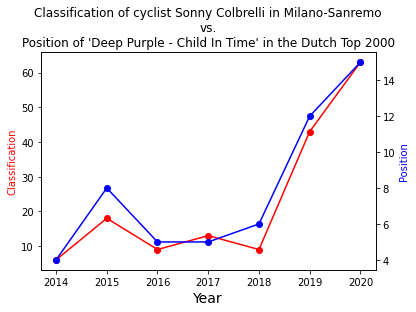

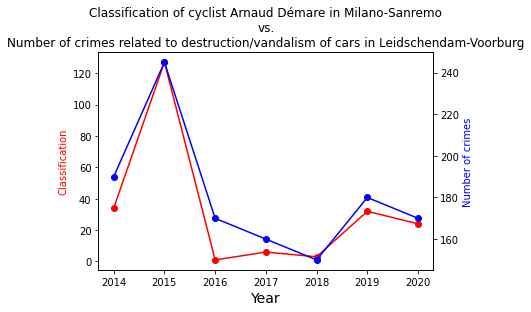

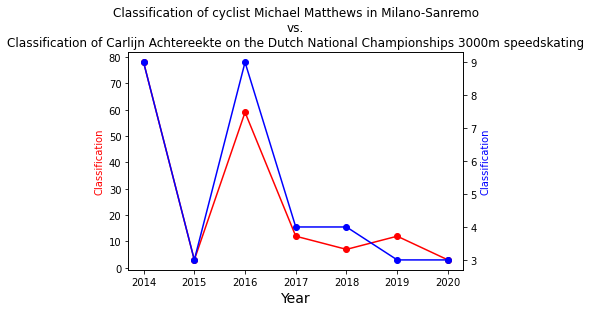

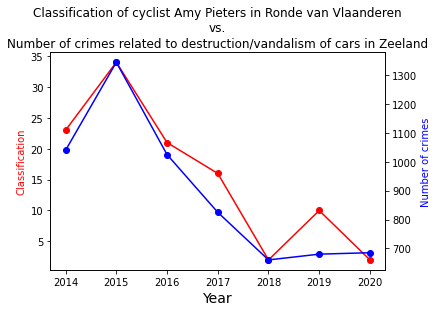

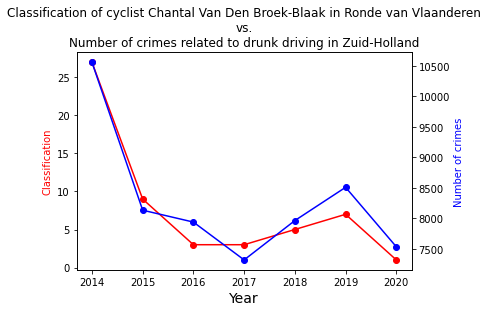

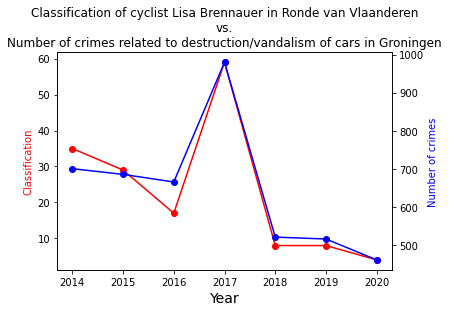

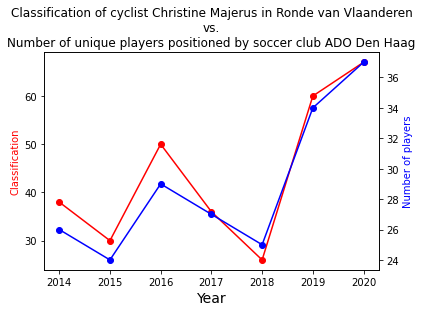

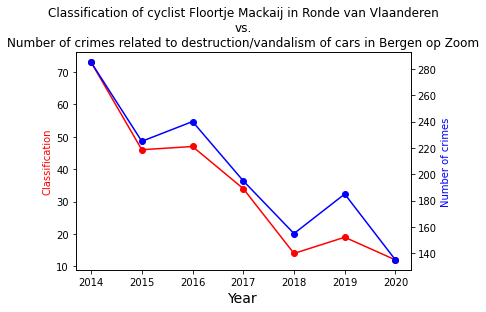

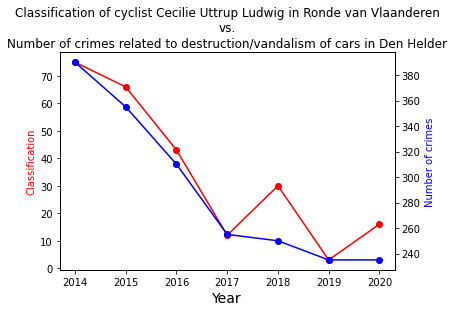

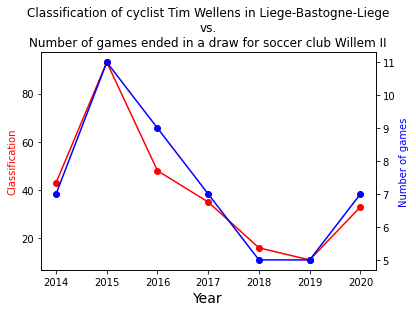

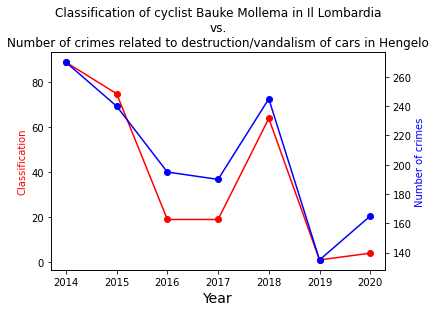

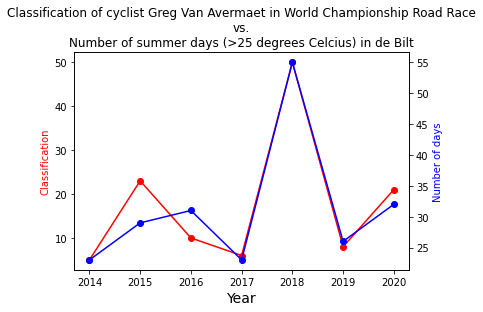

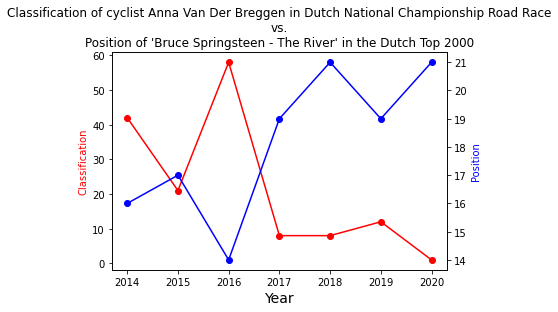

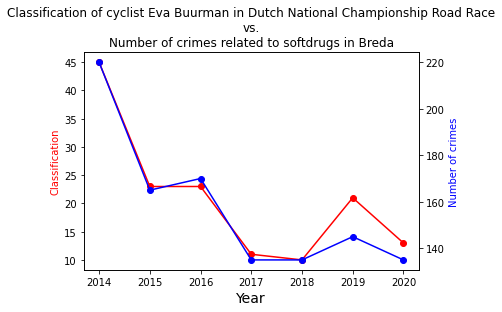

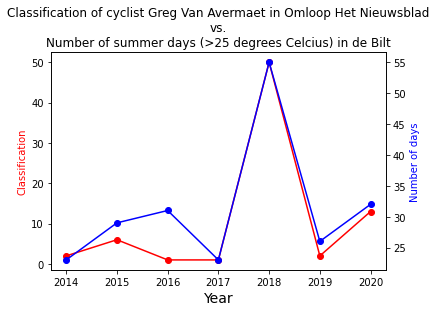

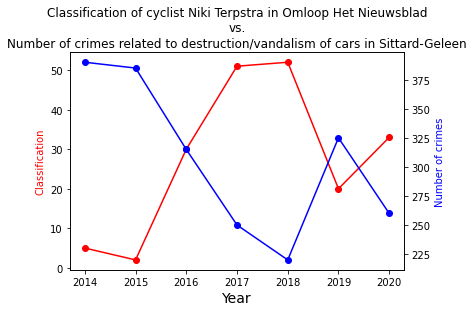

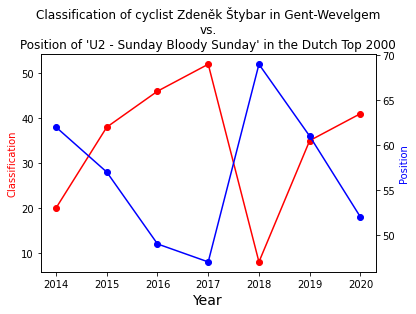

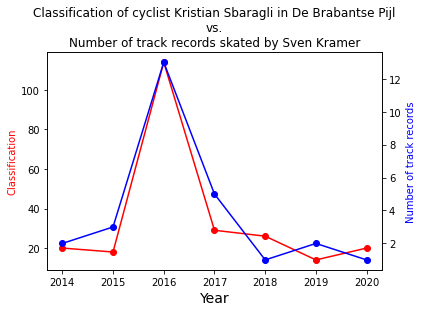

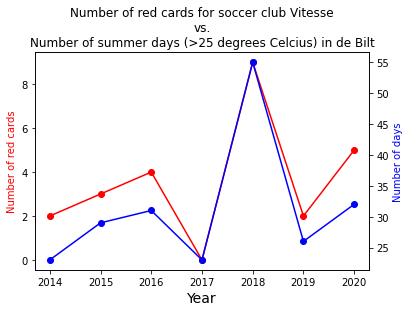

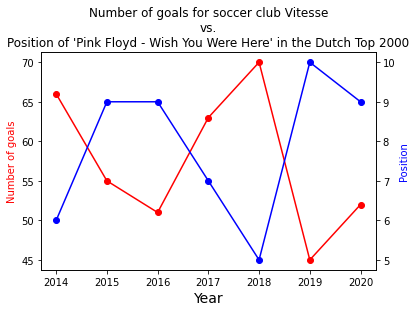

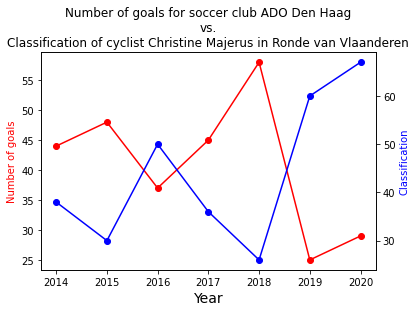

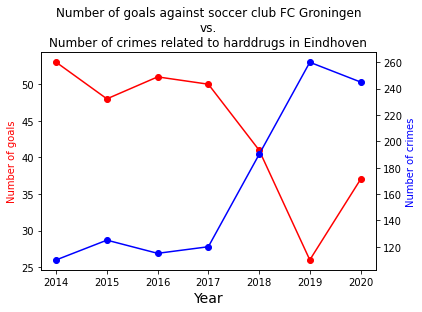

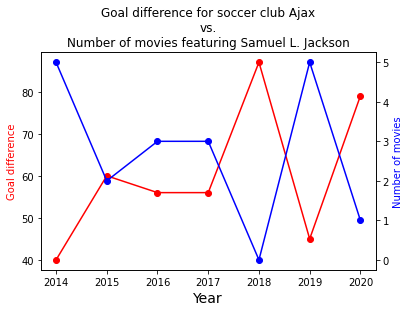

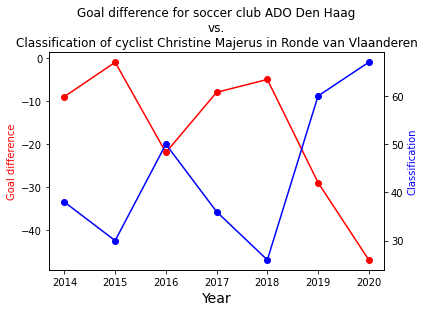

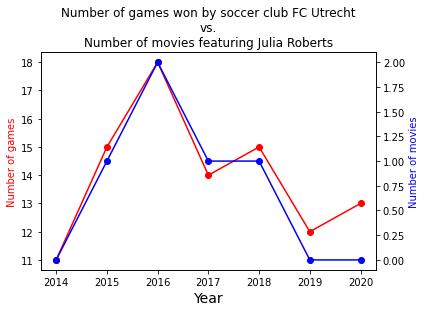

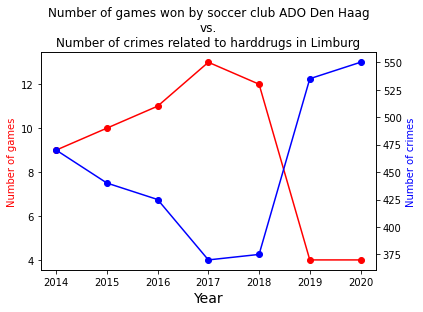

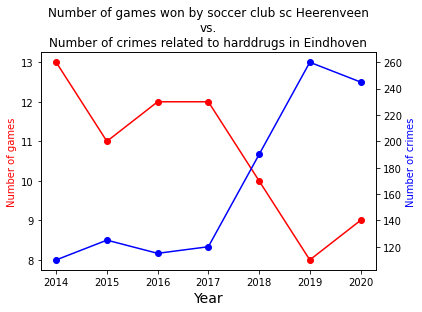

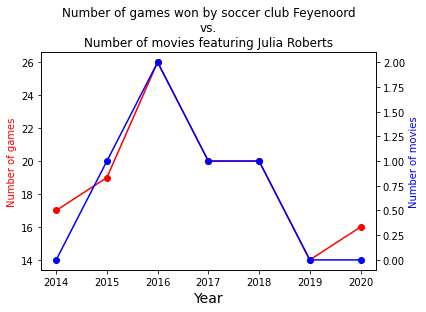

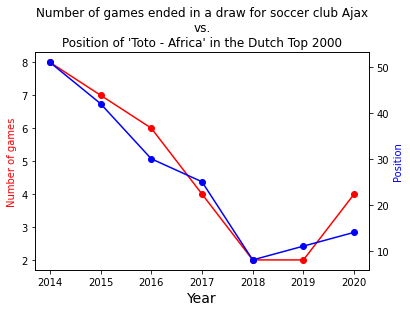

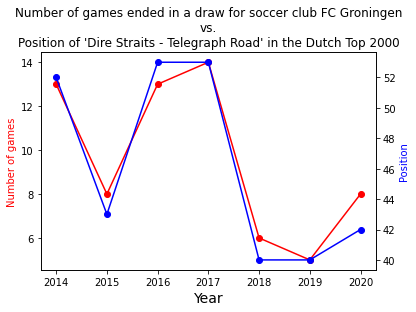

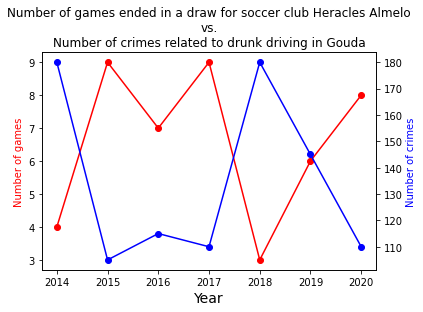

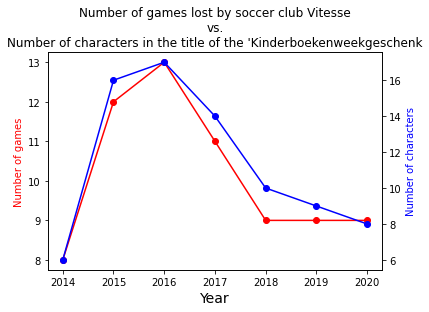

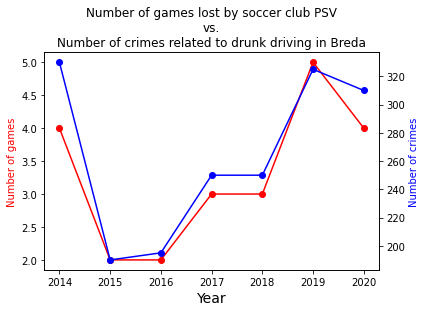

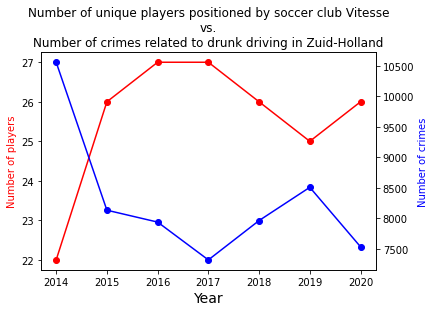

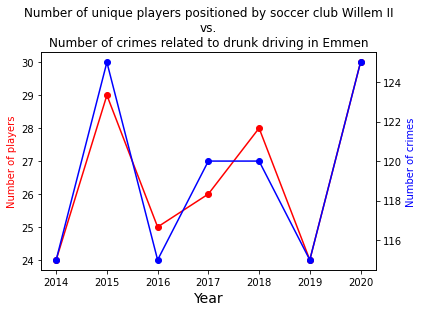

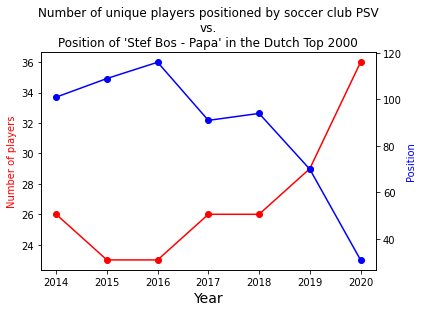

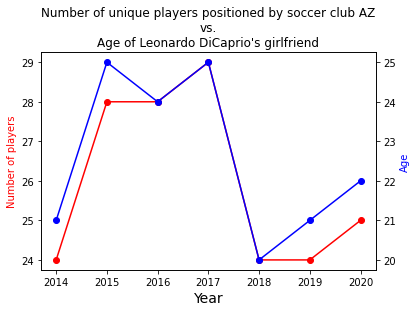

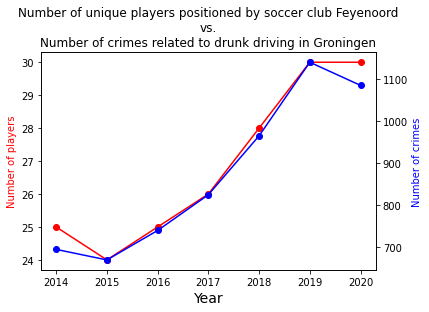

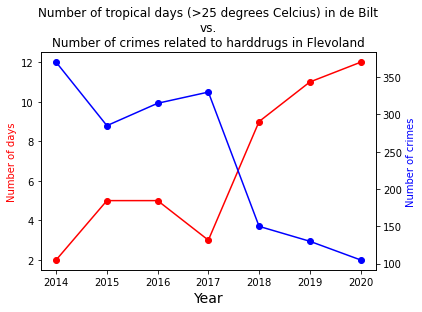

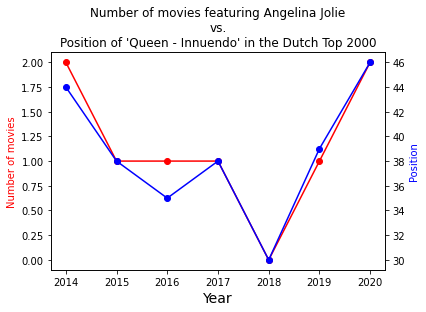

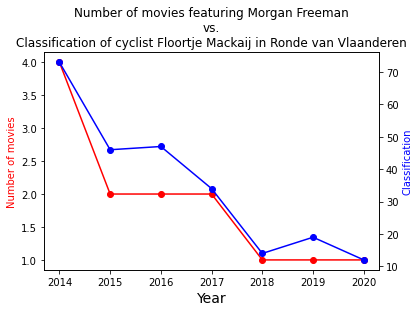

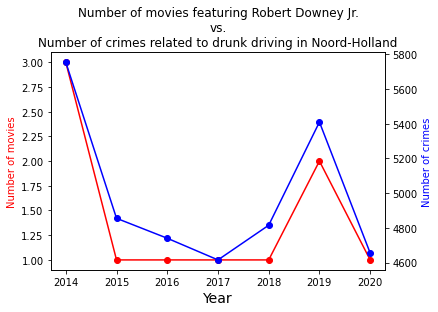

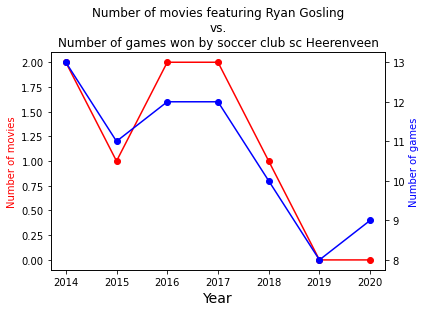

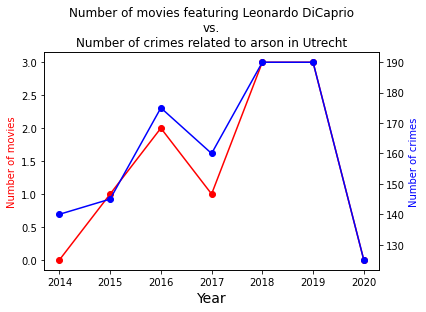

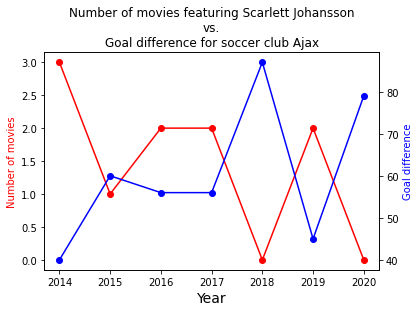

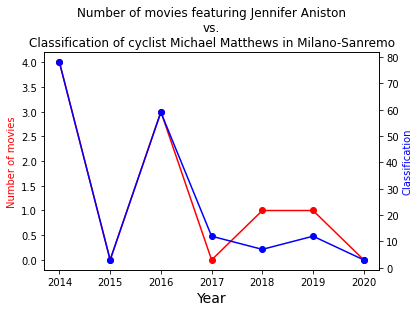

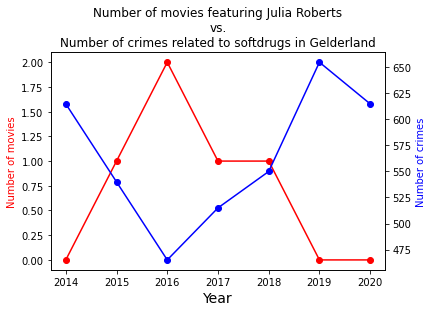

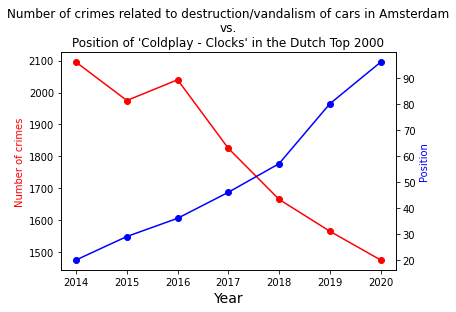

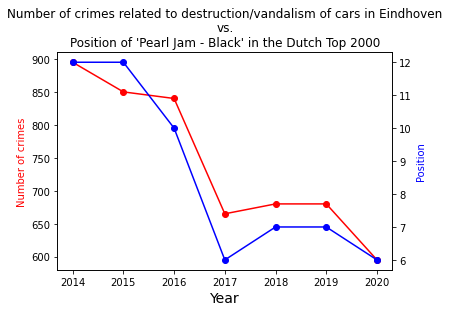

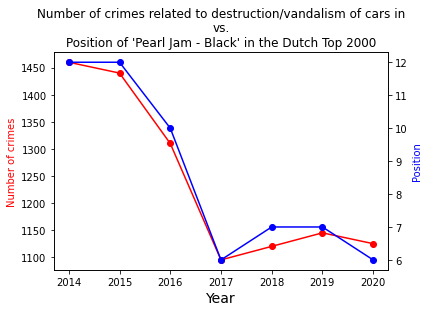

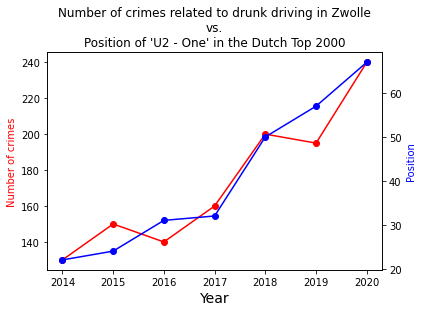

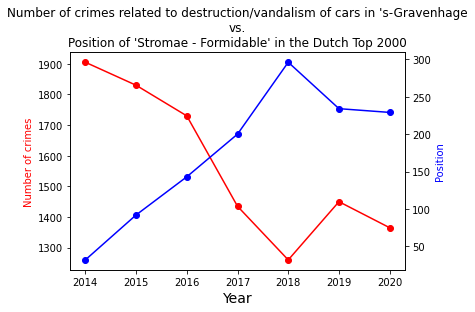

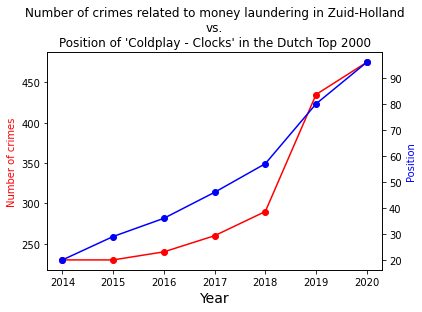

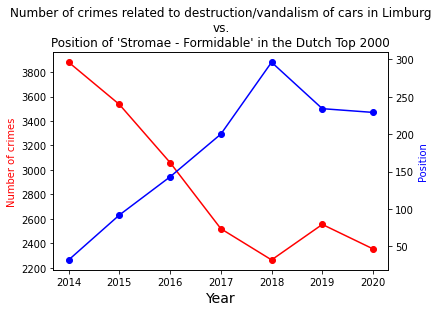

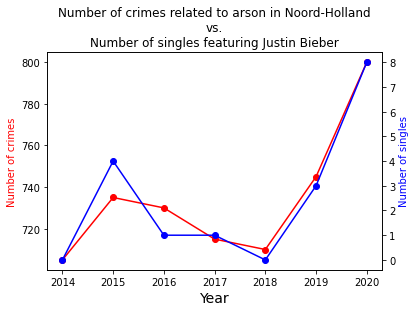

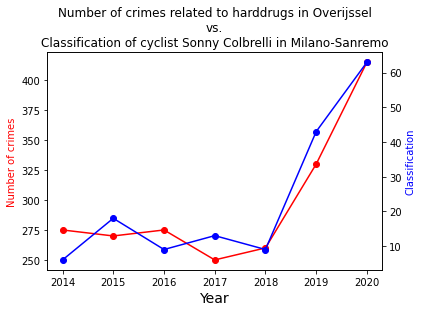

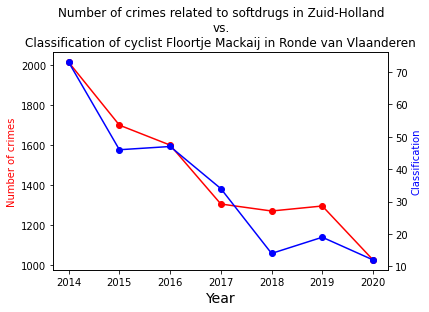

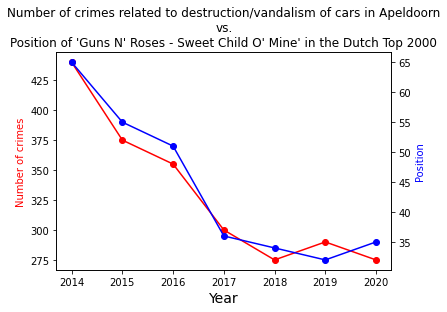

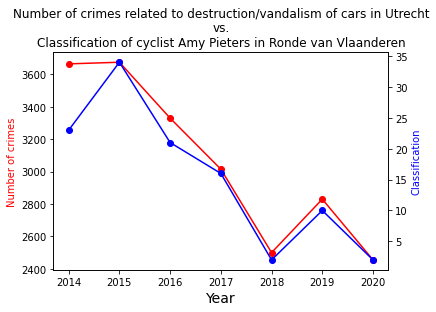

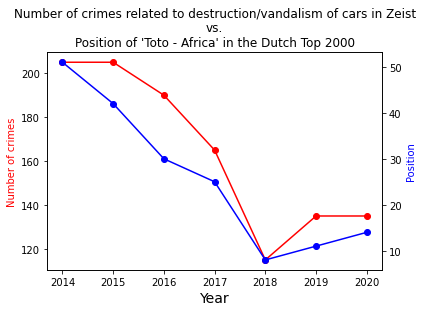

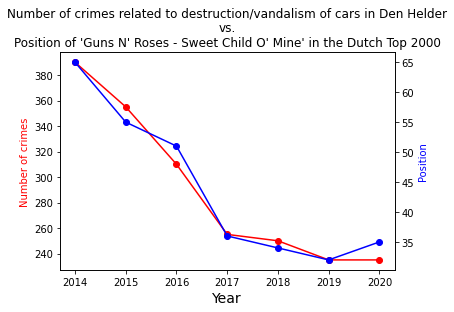

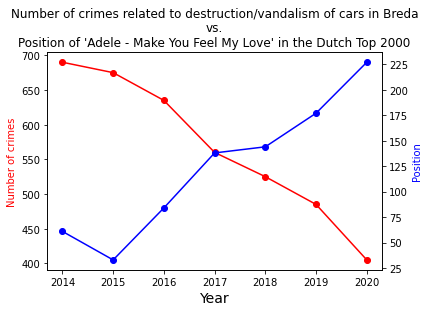

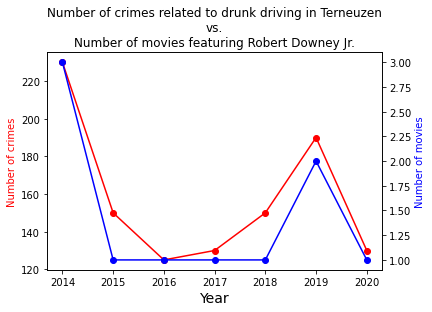

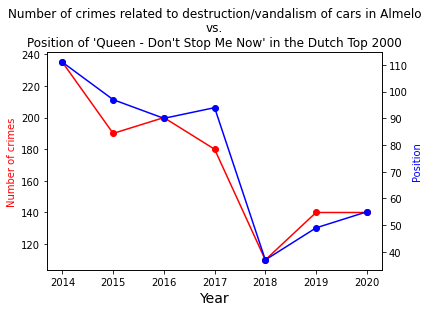

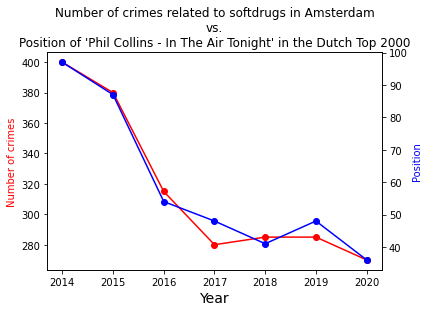

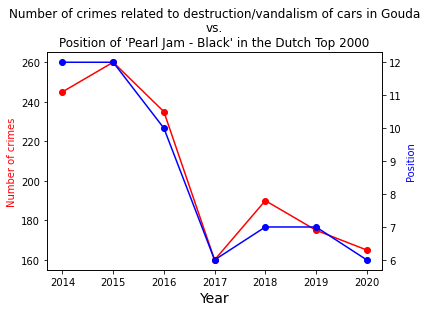

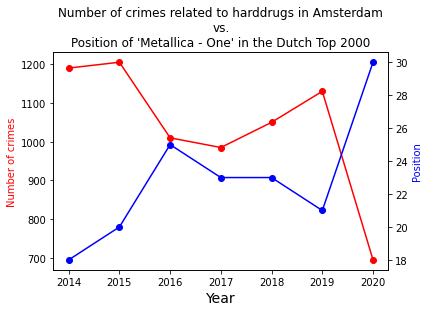

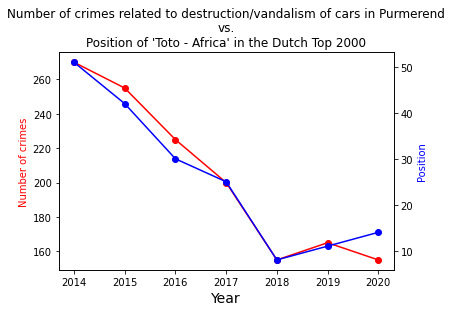

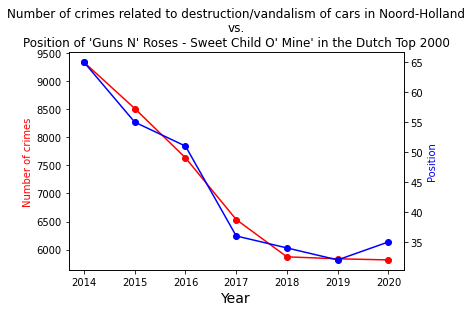

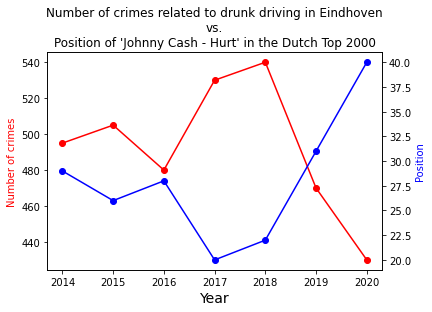

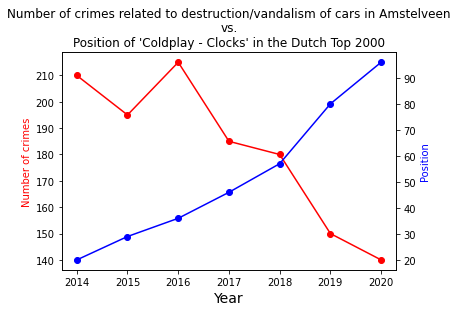

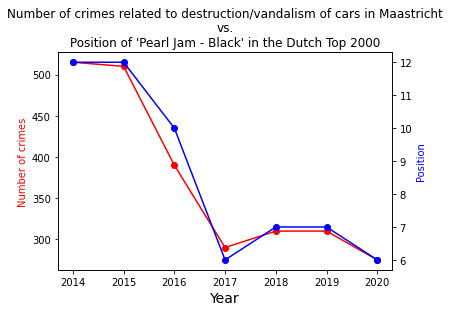

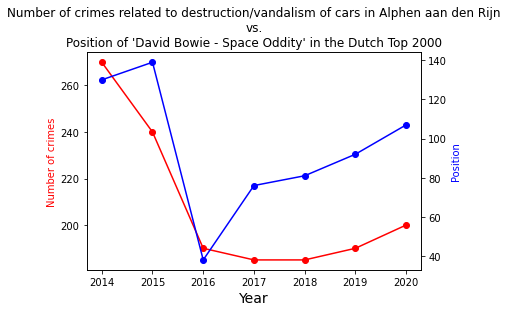

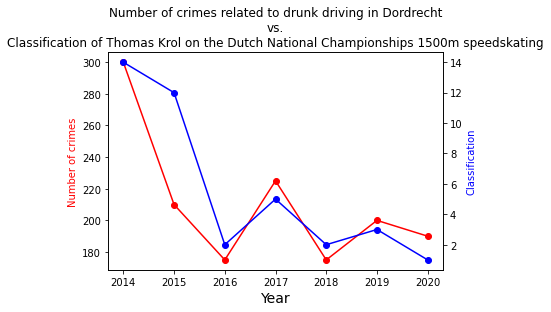

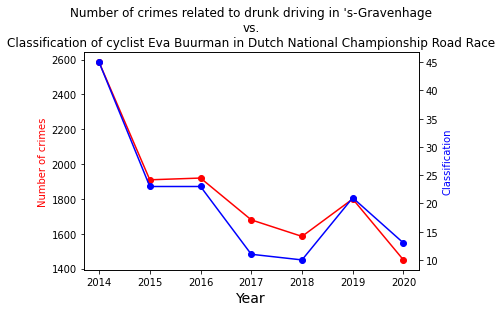

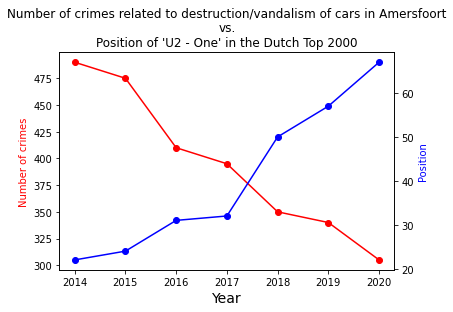

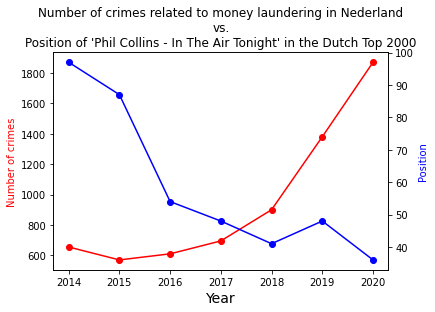

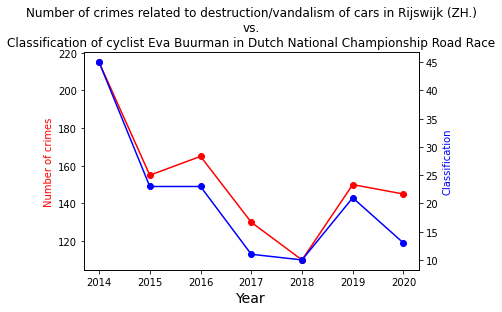

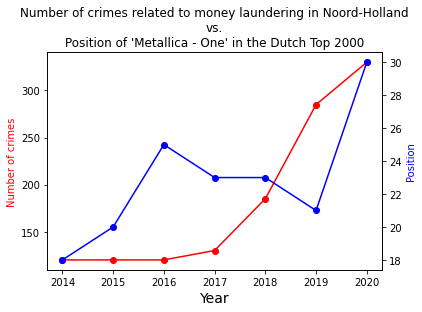

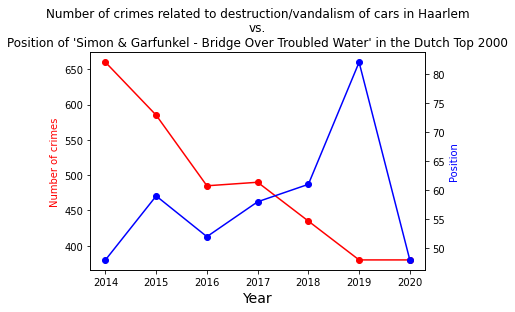

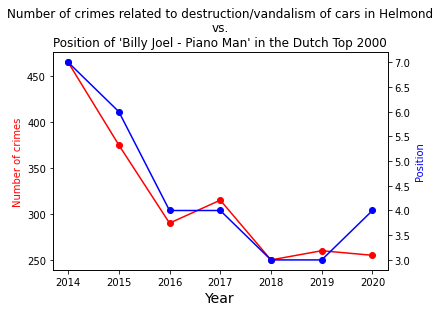

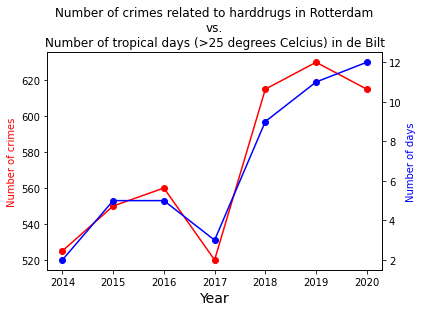

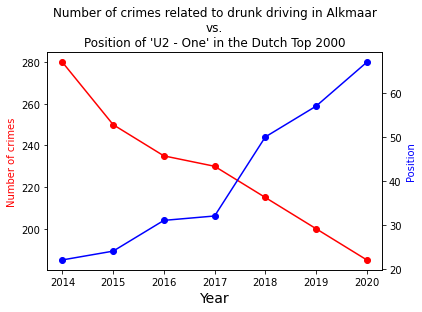

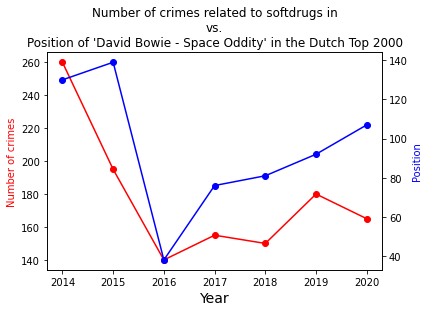

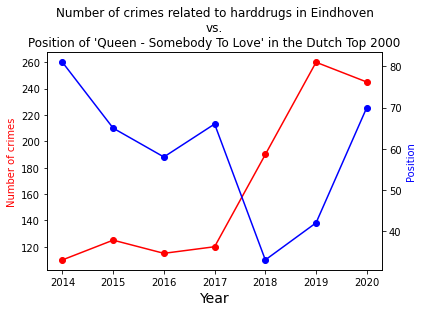

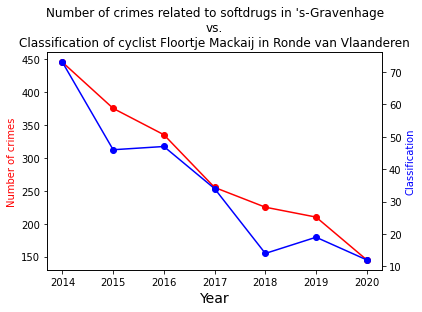

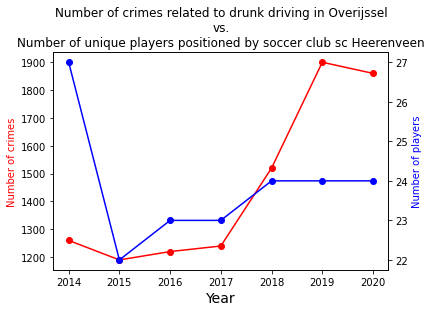

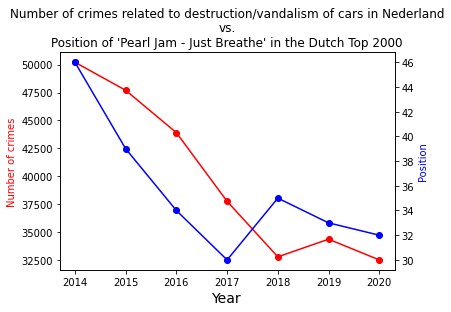

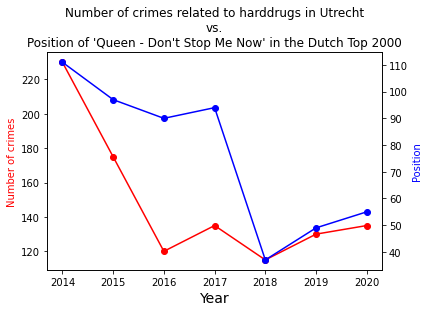

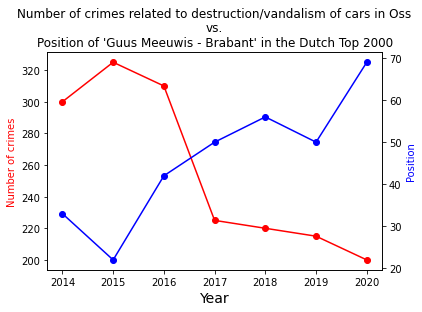

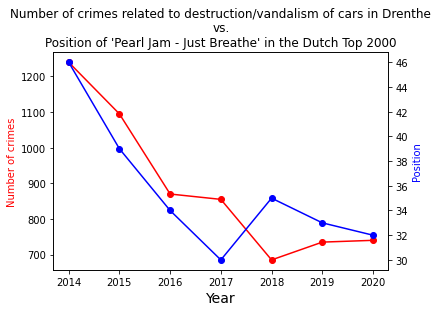

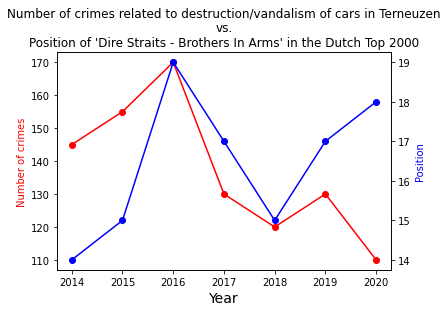

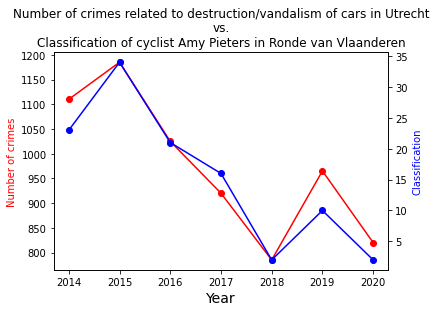

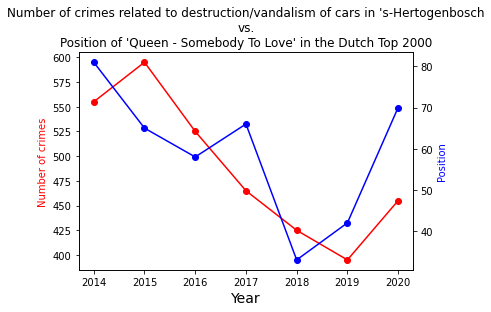

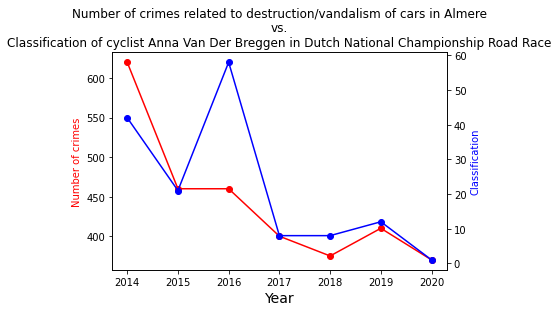

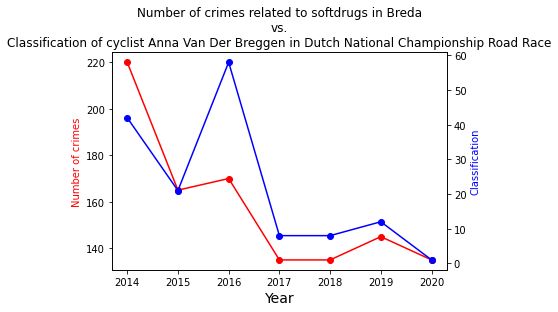

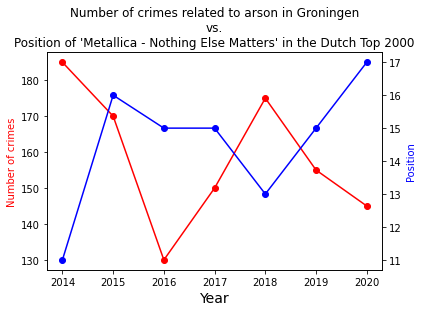

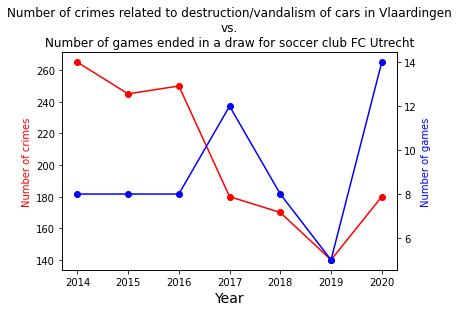

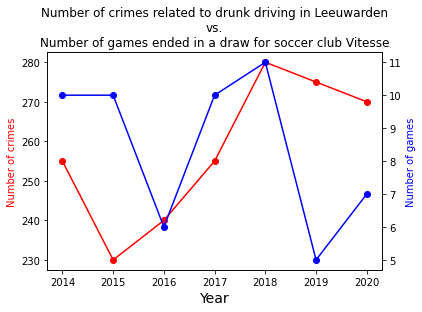

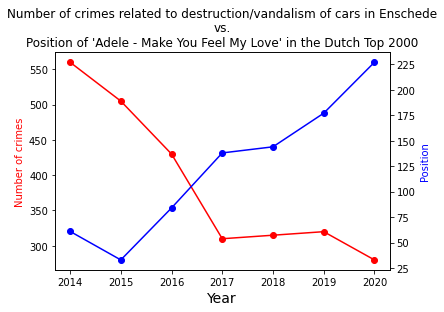

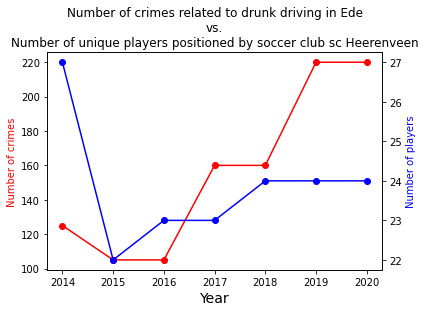

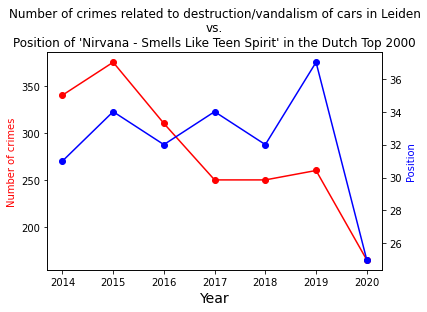

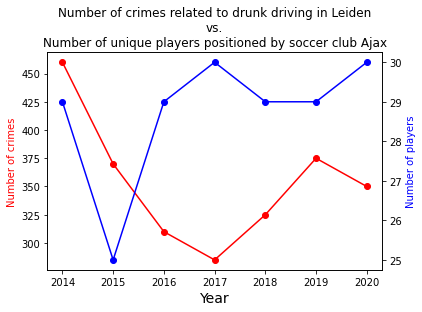

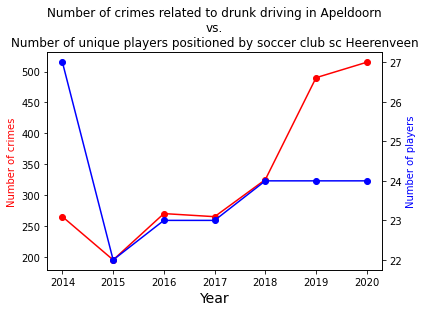

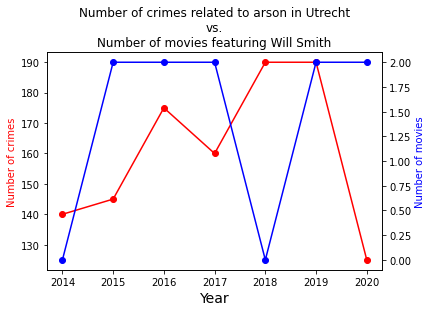

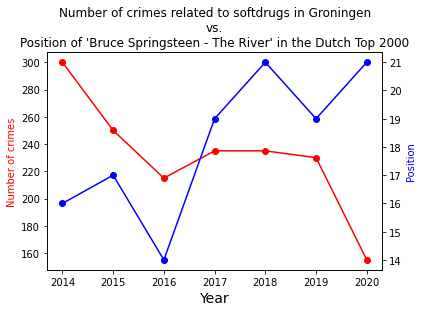

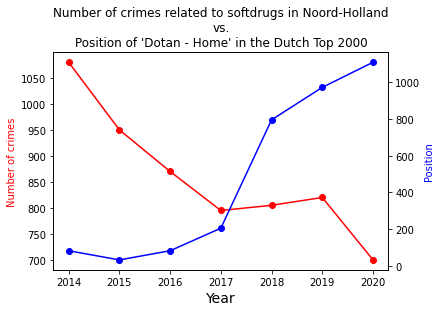

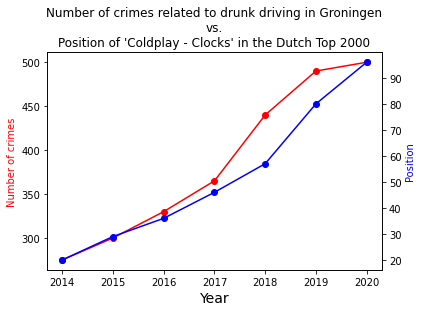

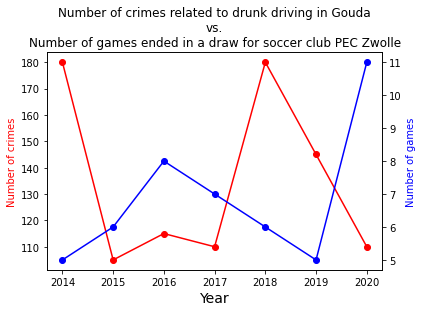

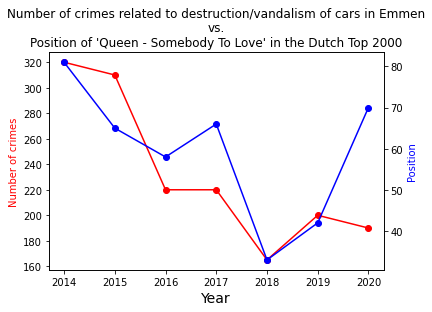

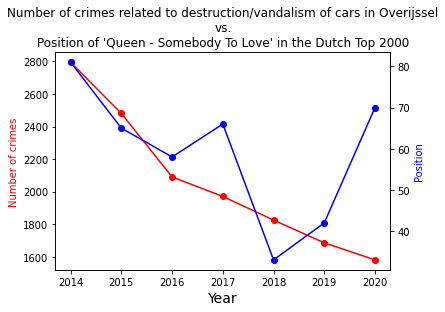

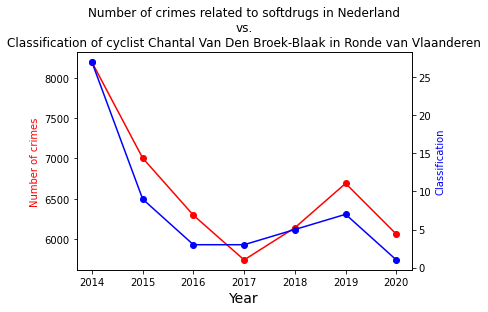

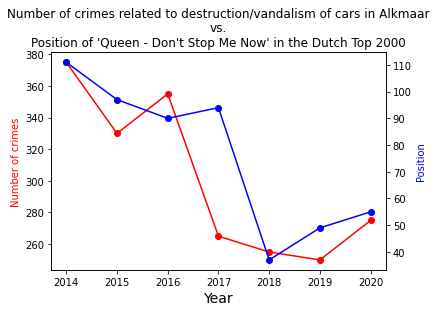

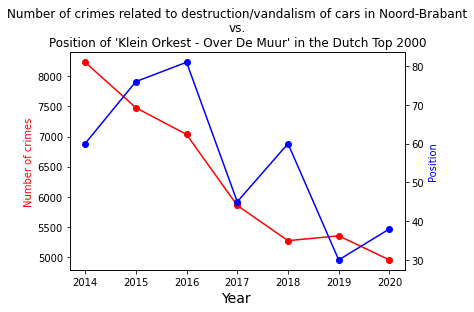

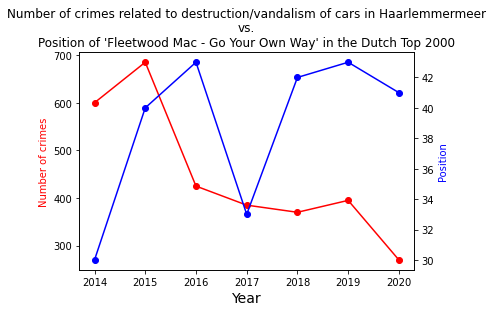

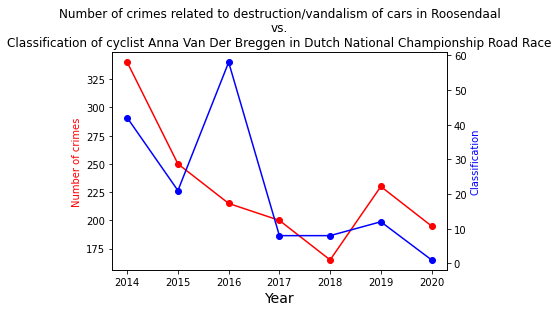

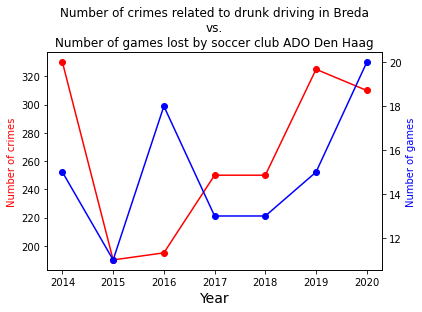

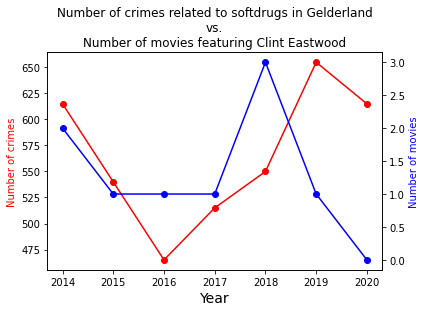

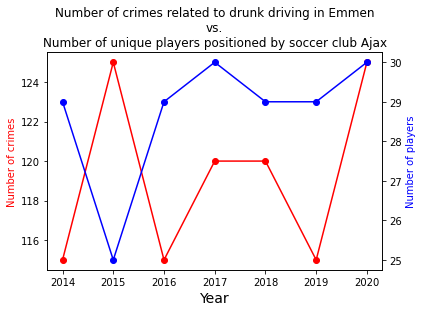

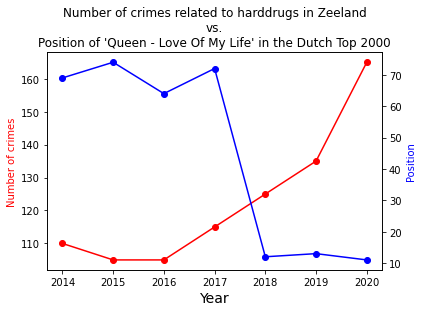

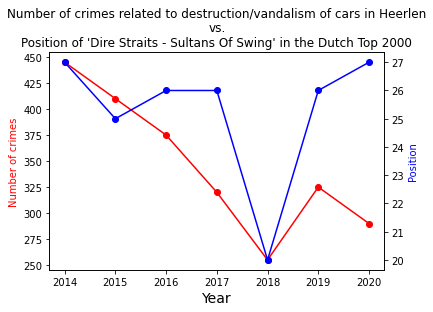

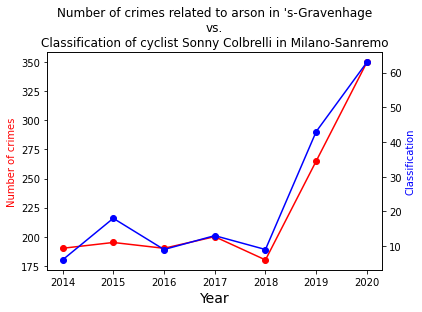

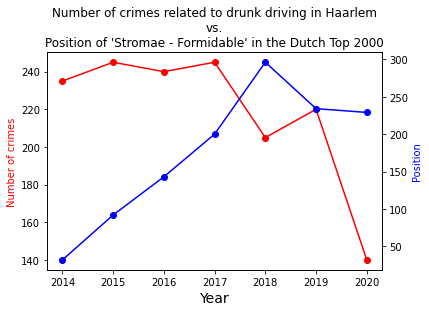

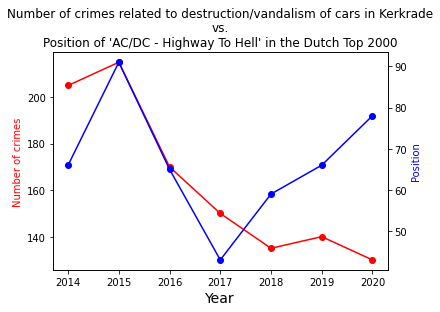

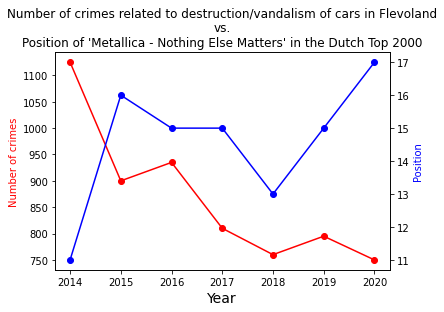

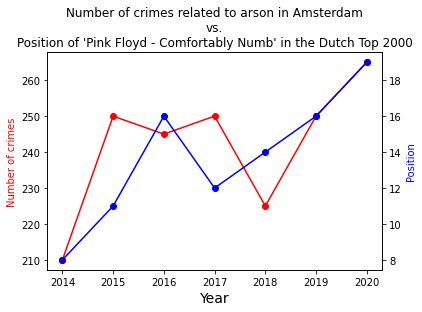

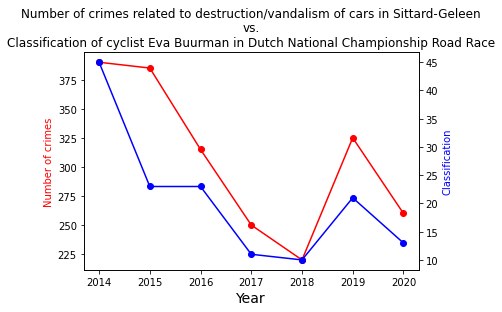

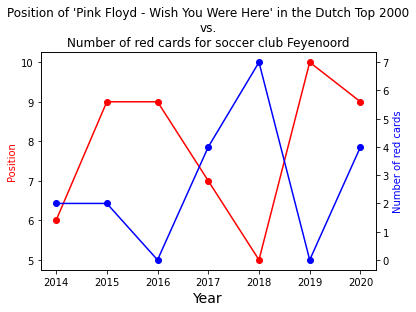

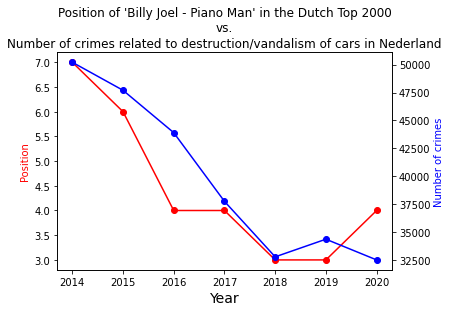

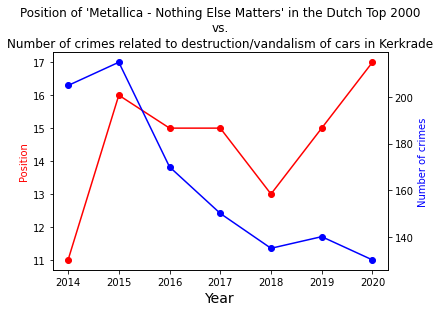

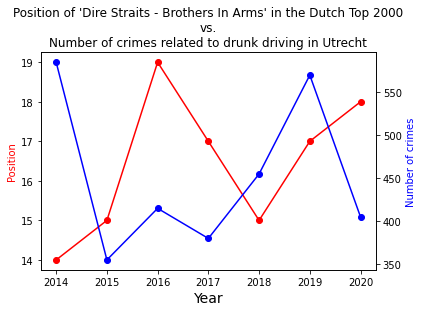

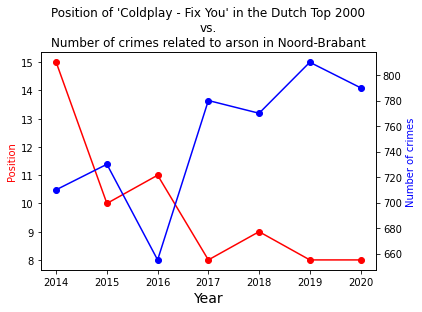

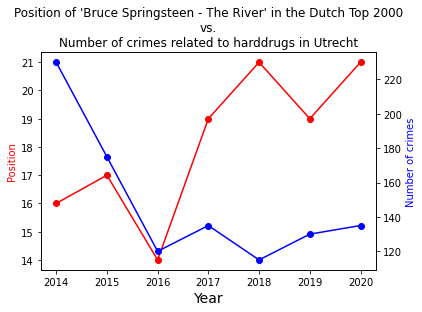

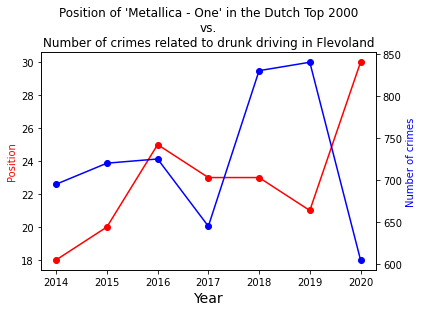

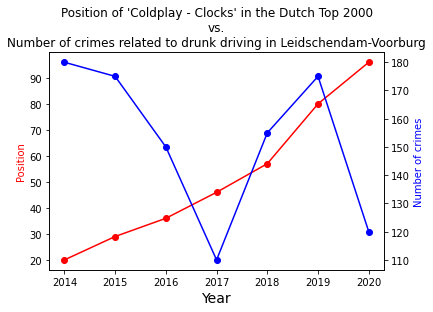

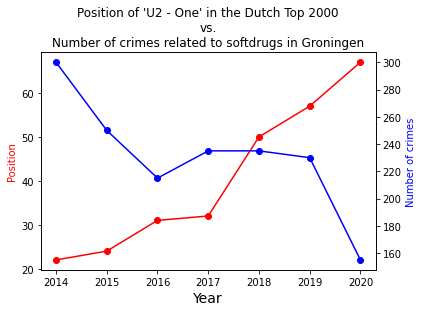

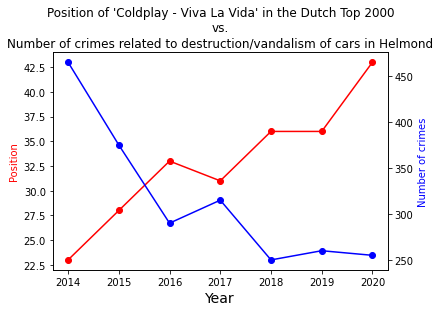

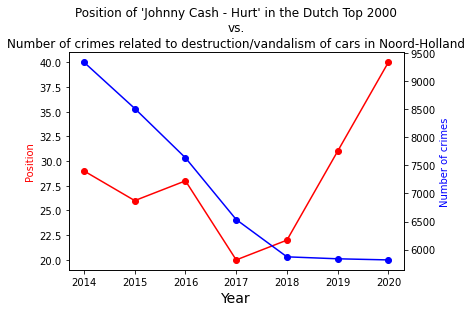

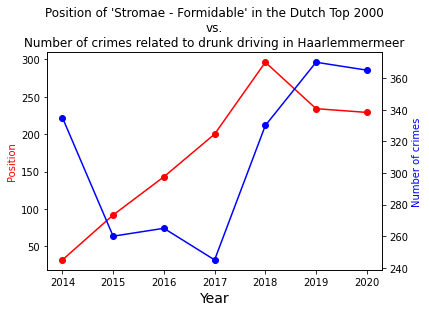

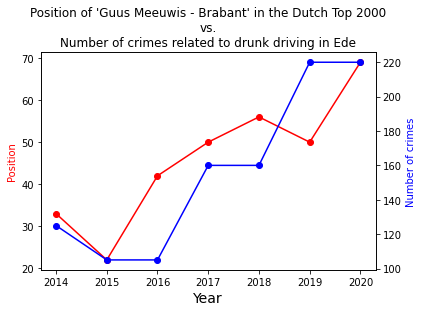

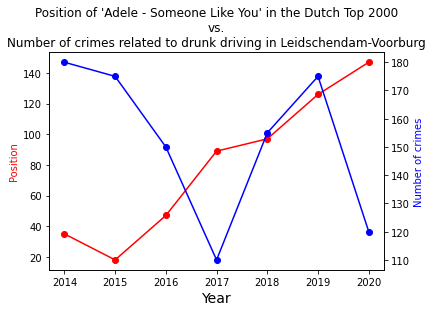

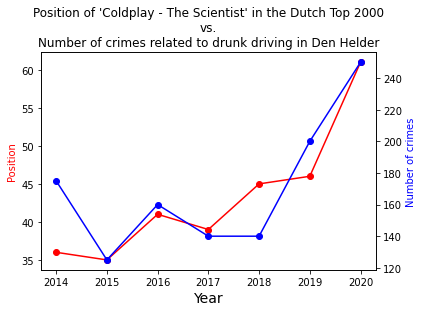

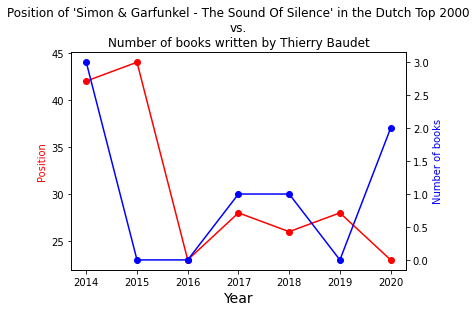

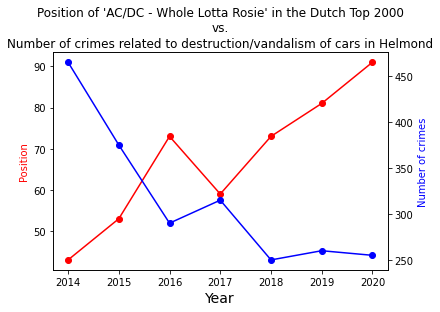

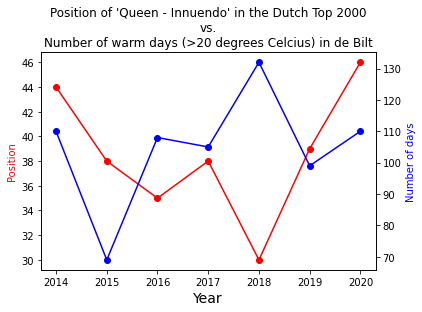

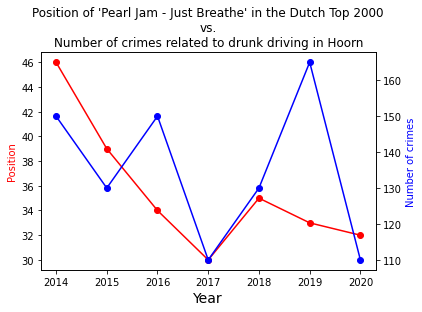

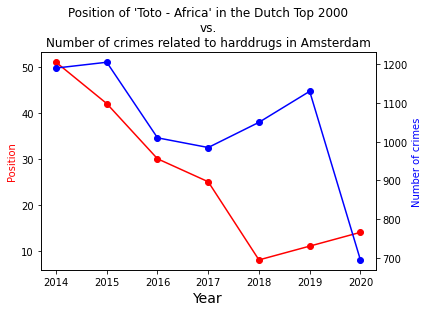

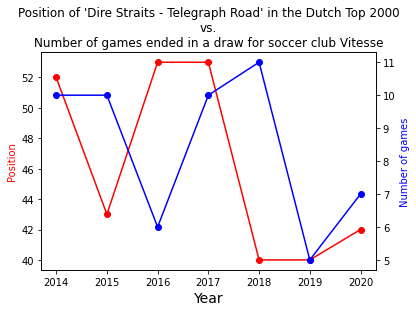

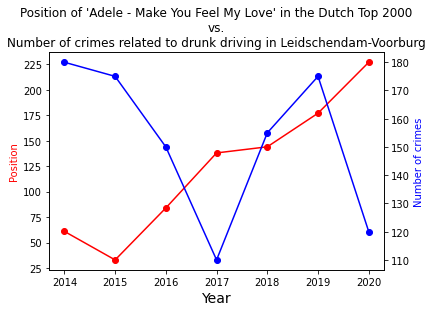

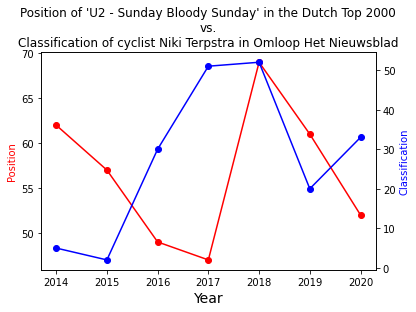

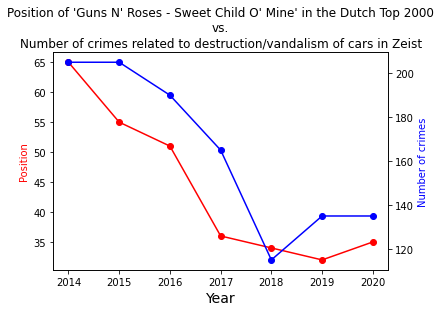

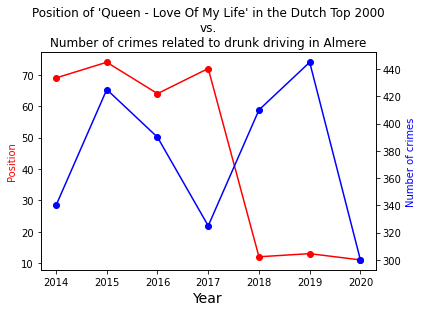

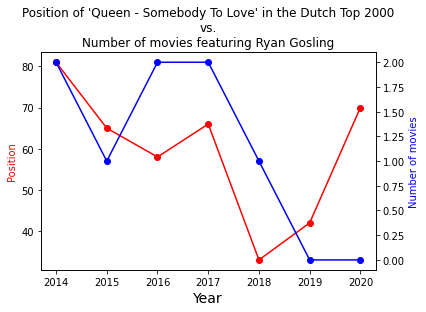

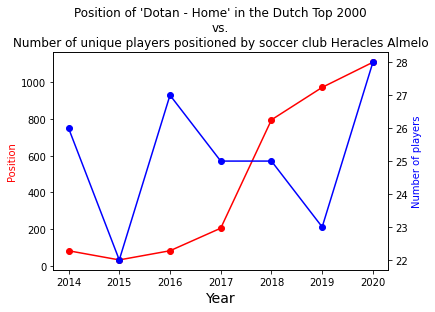

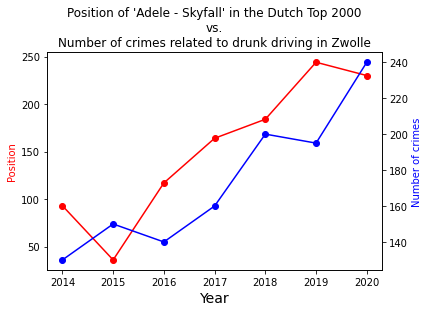

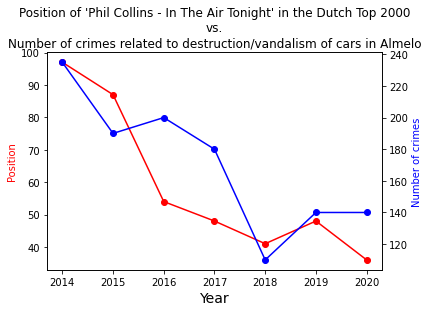

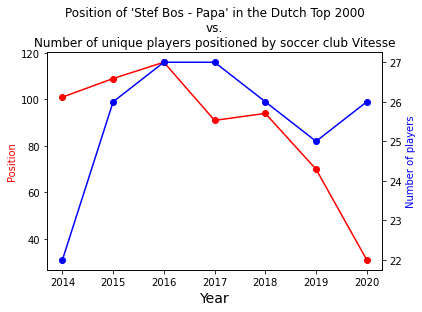

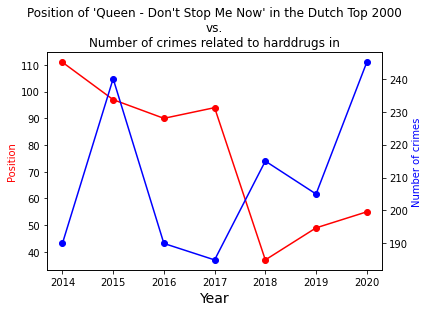

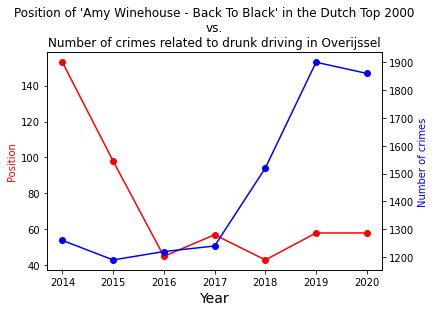

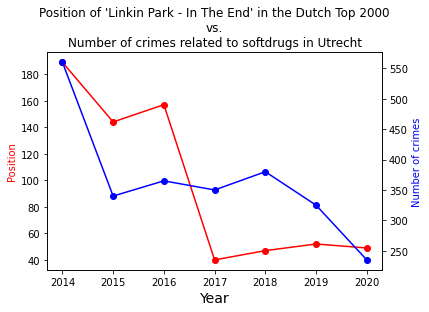

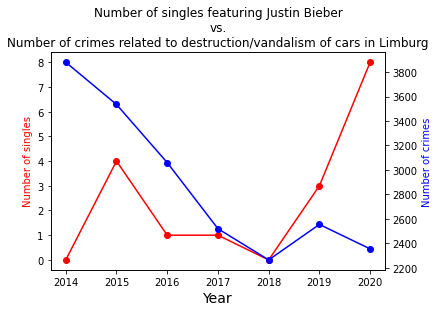

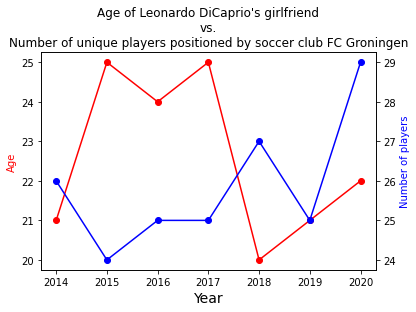

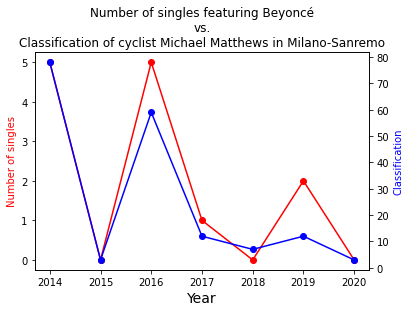

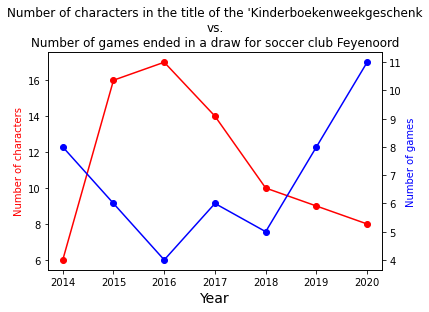

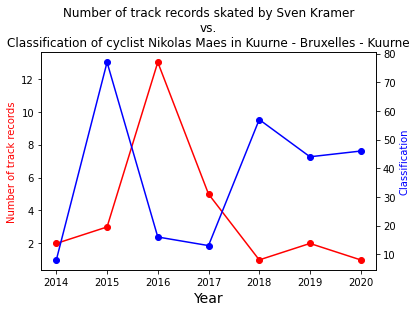

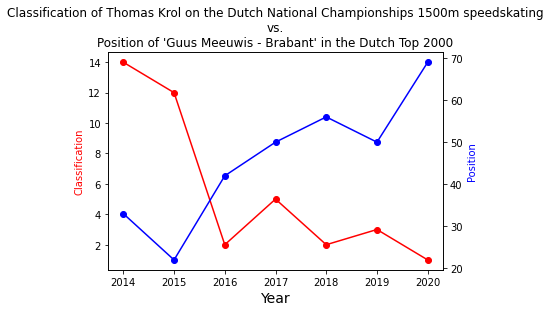

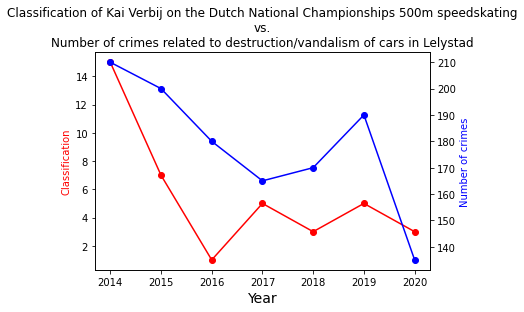

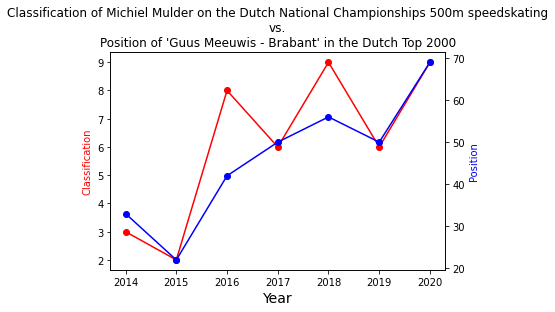

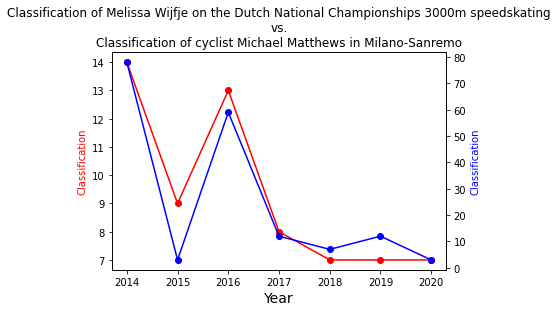

In [80]:
all_data = {
    "Cycling": pcs_time_series,
    "Eredivisie soccer": eredivisie_time_series,
    "Climate": climate_time_series,
    "Movies": imdb_time_series,
    "CBS": crime_time_series,
    "Top 2000": top_2000_time_series,
    "Manual additons": manual_addition_time_series
}
language = "en"

correlated_series = []
used = []
for category1, list1 in all_data.items():
    for series1 in list1:
        data1 = np.array(series1['values'])
        
        other_category_data = [series for category, category_series in all_data.items() for series in category_series if category != category1]
        not_yet_overused_data = [data for data in other_category_data if used.count(data['title']['en']) < 4]
        all_series = np.array([np.array(data['values']) for data in not_yet_overused_data])
        
        max_correlation, max_correlation_idx = find_max_correlation(data1, all_series)
        series2 = other_category_data[max_correlation_idx]
        
        if abs(max_correlation) > 0.95 and [series2, series1, correlation] not in correlated_series:
            correlated_series.append([series1, series2, correlation])
            used.append(series1['title']['en'])
            used.append(series2['title']['en'])
            plot(series1, series2, years, language)

# Saving the dataset to JSON

In [ ]:
import json
import random

with open('all_data.json', 'w') as outfile:
    json.dump(time_series, outfile, indent=4)

random.shuffle(correlated_series)
print(correlated_series)
with open('correlated_series.json', 'w') as outfile:
    json.dump(correlated_series, outfile, indent=4)